In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tuna

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import dill
import os
import seaborn as sns
import torch
import pandas as pd

from collections import namedtuple
from hmmlearn.hmm import MultinomialHMM
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from spn.algorithms.Inference import log_likelihood

from rspnlib.models import RSPN, EMTrainingParams
from rspnlib.models.hmm import HmmRSPN
from rspnlib.models.iohmm import (
    IoHmmRSPN,
    ExtendedIoHmmRSPN,
    ContinuousIoHmmRSPN,
    OverparametrisedIoHmmRSPN,
    OverparametrisedContinuousIoHmmRSPN,
    ExtendedOverparametrisedContinuousIoHmmRSPN,
)
from rspnlib.evaluation import (
    compute_metrics,
    get_empty_metrics,
    add_metrics,
    print_aggregate_metrics,
    evaluate_rspn_one_step_ahead_prediction,
    evaluate_rspn_observation_regression,
)
from experiment_utils.datasets.weather_dataset import create_weather_hmm, generate_weather_datasets
from experiment_utils.datasets.engine_dataset import create_engine_iohmm, create_continuous_engine_iohmm, generate_engine_datasets, get_engine_parameters
from experiment_utils.datasets.vasopressors_dataset import load_vasopressors_dataset
from experiment_utils.datasets.mimic_continuous_dataset import load_mimic_dataset
from experiment_utils.baselines.lstm import train_eval_lstm
from experiment_utils.baselines.most_common_class import train_eval_most_common_baseline

# HMM Experiments

## Reference HMM
We use a simple proof-of-concept HMM implementing the following model (inspired by [Wikipedia](https://en.wikipedia.org/wiki/Hidden_Markov_model#Weather_guessing_game)):

```
states = ('Rainy', 'Sunny')
 
observations = ('walk', 'drive')
 
start_probability = {'Rainy': 0.65, 'Sunny': 0.35}
transition_probability = {
   'Rainy' : {'Rainy': 0.7, 'Sunny': 0.3},
   'Sunny' : {'Rainy': 0.25, 'Sunny': 0.75},
}
 
emission_probability = {
   'Rainy' : {'walk': 0.2, 'drive': 0.8},
   'Sunny' : {'walk': 0.6, 'drive': 0.4},
}
```

In [2]:
reference_hmm = create_weather_hmm()

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


## Weather Dataset Generation

In [4]:
NUM_SEEDS = 5
TRAIN_SAMPLES = 1000
TEST_SAMPLES = 1000
SEQ_LENGTH = 12
SEEDS = range(42, 42 + NUM_SEEDS)

train_weather_datasets, test_weather_datasets = generate_weather_datasets(
    seeds=SEEDS,
    development_samples=TRAIN_SAMPLES,
    test_samples=TEST_SAMPLES,
    seq_length=SEQ_LENGTH
)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


ValueError: n_trials must be set

## HMM-RSPN
RSPN model for the HMM.

In [ ]:
start_proba = [0.5, 0.5]
trans_proba = [[0.51, 0.49],
               [0.49, 0.51]]
emission_proba = [[0.51, 0.49],
                  [0.49, 0.51]]

simple_hmm_rspn = HmmRSPN(start_proba, trans_proba, emission_proba)

### HMM-RSPN Evaluation

In [ ]:
simple_hmm_rspn = HmmRSPN(start_proba, trans_proba, emission_proba)

In [ ]:
train_data = train_weather_datasets[0].spn_data

In [ ]:
train_data.shape

——————————[ Running experiment for seed 42 ]——————————
Training HmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


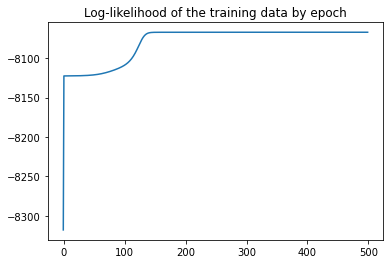

——————————[ Running experiment for seed 43 ]——————————
Training HmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


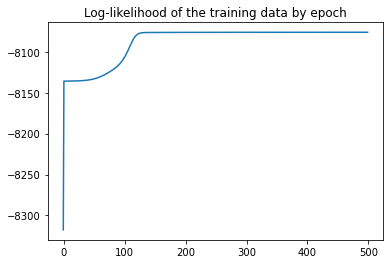

——————————[ Running experiment for seed 44 ]——————————
Training HmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


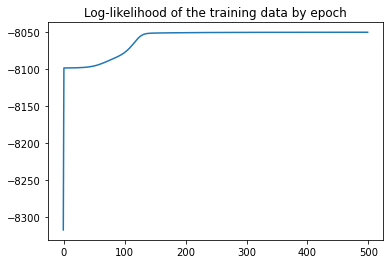

——————————[ Running experiment for seed 45 ]——————————
Training HmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


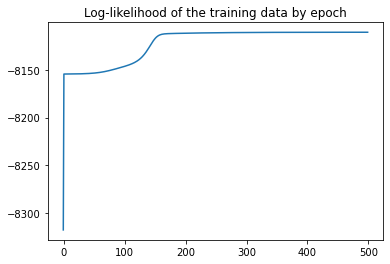

——————————[ Running experiment for seed 46 ]——————————
Training HmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


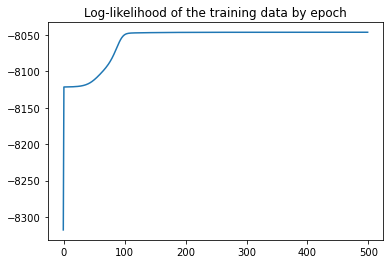

In [ ]:
log_likelihoods = []
hmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    simple_hmm_rspn = HmmRSPN(start_proba, trans_proba, emission_proba)
    train_data = train_weather_datasets[i].spn_data
    optimized_hmm_rspn = simple_hmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_hmm_rspn.unroll(SEQ_LENGTH), test_weather_datasets[i].spn_data).sum()
    log_likelihoods.append(data_log_likelihood)
    hmm_rspn_models.append(optimized_hmm_rspn)

In [ ]:
print("——————————[ HMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

## hmmlearn evaluation

In [ ]:
log_likelihoods = []
hmmlearn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    test_hmm = MultinomialHMM(n_components=2, init_params='', n_iter=500)
    test_hmm.startprob_ = np.array(start_proba)
    test_hmm.transmat_ = np.array(trans_proba)
    test_hmm.emissionprob_ = np.array(emission_proba)
    test_hmm.fit(train_weather_datasets[i].observations_raw.flatten()[:, np.newaxis], lengths=np.full(TRAIN_SAMPLES, SEQ_LENGTH))
    data_log_likelihood = test_hmm.score(test_weather_datasets[i].observations_raw.flatten()[:, np.newaxis], lengths=np.full(TEST_SAMPLES, SEQ_LENGTH))
    log_likelihoods.append(data_log_likelihood)
    hmmlearn_models.append(test_hmm)

In [ ]:
print("——————————[ hmmlearn HMM log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

### Reference HMM evaluation

In [ ]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    data_log_likelihood = reference_hmm.score(test_weather_datasets[i].observations_raw.flatten()[:, np.newaxis], lengths=np.full(TEST_SAMPLES, SEQ_LENGTH))
    log_likelihoods.append(data_log_likelihood)

In [ ]:
print("——————————[ Reference HMM log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

# IOHMM Observation Prediction Experiments

## Engine Dataset Generation
We define a synthetic dataset corresponding to an IOHMMs with the following parameters:

```
inputs = ('standard', 'flank')

states = ('nominal', 'overheating')
 
observations = ('speed', 'fuel consumption')

inputs_prior = {
    'standard': 0.7,
    'flank': 0.3,
}
 
start_probability = {
    'standard': {'nominal': 0.9, 'overheating': 0.1},
    'flank':    {'nominal': 0.7, 'overheating': 0.3},
}

transition_probability = {
   ('nominal', 'standard'):     {'nominal': 0.9, 'overheating': 0.1},
   ('nominal', 'flank'):        {'nominal': 0.5, 'overheating': 0.5},
   ('overheating', 'standard'): {'nominal': 0.6, 'overheating': 0.4},
   ('overheating', 'flank'):    {'nominal': 0.1, 'overheating': 0.9},
}

# Discrete case
observation_probas = {
   ('standard', 'nominal'): {
       ('speed medium', 'consumption low'):  0.7,
       ('speed medium', 'consumption high'): 0.2,
       ('speed high', 'consumption low'):    0.05,
       ('speed high', 'consumption high'):   0.05,
   },
   ('standard', 'overheating'): {
       ('speed medium', 'consumption low'):  0.2,
       ('speed medium', 'consumption high'): 0.78,
       ('speed high', 'consumption low'):    0.01,
       ('speed high', 'consumption high'):   0.01,
    },
   ('flank', 'nominal'): {
       ('speed medium', 'consumption low'):  0.09
       ('speed medium', 'consumption high'): 0.12,
       ('speed high', 'consumption low'):    0.05,
       ('speed high', 'consumption high'):   0.74,
   },
   ('flank', 'overheating'): {
       ('speed medium', 'consumption low'):  0.1,
       ('speed medium', 'consumption high'): 0.68,
       ('speed high', 'consumption low'):    0.02,
       ('speed high', 'consumption high'):   0.2,
    }
}

# Continuous case
observation_means = {
   ('standard', 'nominal'):     {('speed', 'fuel_consumption'): (50, 50)},
   ('standard', 'overheating'): {('speed', 'fuel_consumption'): (40, 70)},
   ('flank', 'nominal'):        {('speed', 'fuel_consumption'): (70, 75)},
   ('flank', 'overheating'):    {('speed', 'fuel_consumption'): (60, 100)},
}

observation_covars = {
   ('standard', 'nominal'):     {('speed', 'fuel_consumption'): [[15, 0], [0, 15]]},
   ('standard', 'overheating'): {('speed', 'fuel_consumption'): [[15, 0], [0, 15]]},
   ('flank', 'nominal'):        {('speed', 'fuel_consumption'): [[15, 0], [0, 15]]},
   ('flank', 'overheating'):    {('speed', 'fuel_consumption'): [[15, 0], [0, 15]]},
}
```

In [5]:
NUM_SEEDS = 5
TRAIN_SAMPLES = 1000
TEST_SAMPLES = 1000
SEQ_LENGTH = 12
SEEDS = range(42, 42 + NUM_SEEDS)

train_engine_datasets, test_engine_datasets = generate_engine_datasets(
    seeds=SEEDS,
    development_samples=TRAIN_SAMPLES,
    test_samples=TEST_SAMPLES,
    seq_length=SEQ_LENGTH,
)

## Reference IOHMM

In [6]:
reference_io_hmm_rspn = create_engine_iohmm()

## IOHMM RSPN
An RSPN implementing an IOHMM model

In [7]:
# Specify the initial IOHMM parameters
prior_proba = [0.51, 0.49]
start_proba = [[0.51, 0.49],
               [0.49, 0.51]]
trans_proba = [[[0.51, 0.49],
                [0.49, 0.51]],
               
               [[0.51, 0.49],
                [0.49, 0.51]]]

# Discrete case
emission_proba = [[[0.26, 0.247, 0.247, 0.246],
                   [0.246, 0.26, 0.247, 0.247]],
              
                  [[0.247, 0.246, 0.26, 0.247],
                   [0.247, 0.247, 0.246, 0.26]]]

io_hmm_rspn = IoHmmRSPN(prior_proba, start_proba, trans_proba, emission_proba)

### IOHMM-RSPN Engine Training and Likelihood Evaluation

——————————[ Running experiment for seed 42 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -18961.091280804038 (AVG: -18.961091280804037)


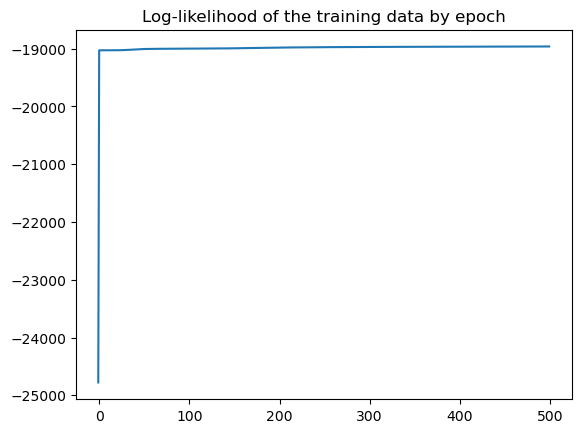

——————————[ Running experiment for seed 43 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -18989.39917972097 (AVG: -18.98939917972097)


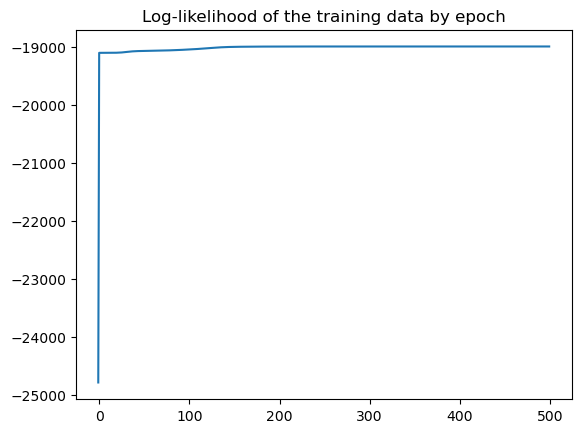

——————————[ Running experiment for seed 44 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -18807.90627327838 (AVG: -18.80790627327838)


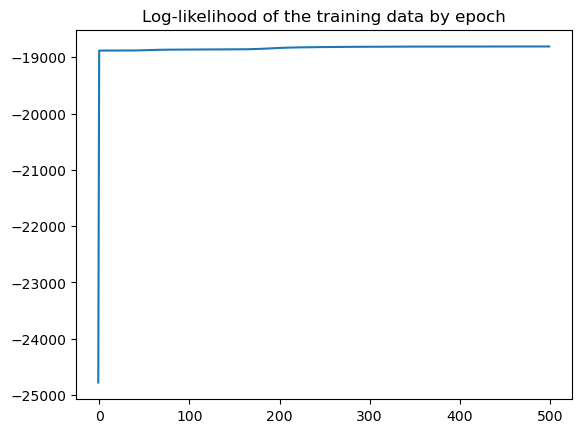

——————————[ Running experiment for seed 45 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -18786.007122171708 (AVG: -18.786007122171707)


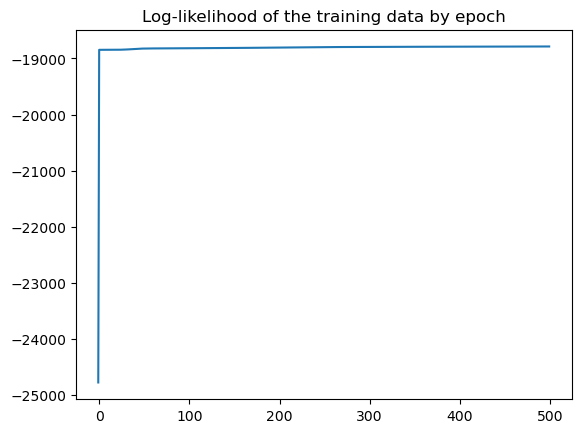

——————————[ Running experiment for seed 46 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -19021.504300683577 (AVG: -19.021504300683578)


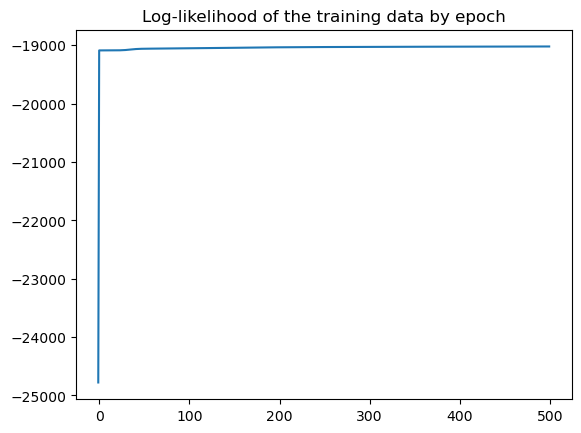

In [8]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    iohmm_rspn = IoHmmRSPN(prior_proba, start_proba, trans_proba, emission_proba)
    train_data = train_engine_datasets[i].spn_data_discrete
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_engine_datasets[i].spn_data_discrete).sum()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [13]:
print("——————————[ IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ IOHMM-RSPN log-likelihood ]——————————
Mean: -18925.66451715843
STD: 84.36584125523947
All: [-19064.772287185922, -18879.62437450049, -18974.976403083372, -18826.638772662045, -18882.310748360338]
Median seed: 46


### Reference IOHMM Engine Likelihood Evaluation

In [14]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    data_log_likelihood = log_likelihood(reference_io_hmm_rspn.unroll(SEQ_LENGTH), test_engine_datasets[i].spn_data_discrete).sum()
    log_likelihoods.append(data_log_likelihood)

——————————[ Running experiment for seed 42 ]——————————
——————————[ Running experiment for seed 43 ]——————————
——————————[ Running experiment for seed 44 ]——————————
——————————[ Running experiment for seed 45 ]——————————
——————————[ Running experiment for seed 46 ]——————————


In [11]:
print("——————————[ Reference IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Reference IOHMM-RSPN log-likelihood ]——————————
Mean: -18925.66451715843
STD: 84.36584125523947
All: [-19064.772287185922, -18879.62437450049, -18974.976403083372, -18826.638772662045, -18882.310748360338]
Median seed: 46


### IOHMM-RSPN Engine Classification Evaluation

In [12]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = evaluate_rspn_one_step_ahead_prediction(iohmm_rspn_models[i], test_engine_datasets[i], [2], 2, identifier=f"seed {seed}")
    add_metrics(aggregate_metrics, metrics)

——————————[ Running classification evaluation for seed 42 ]——————————
              precision    recall  f1-score   support

           0       0.61      0.93      0.74      5061
           1       0.46      0.25      0.33      3824
           2       0.00      0.00      0.00       461
           3       0.40      0.30      0.34      1654

    accuracy                           0.56     11000
   macro avg       0.37      0.37      0.35     11000
weighted avg       0.50      0.56      0.50     11000

AUROC (macro): 0.6672404767668743
AUROC (weighted): 0.6835884153427456
Original Brier: 0.5560053252464489
——————————[ Running classification evaluation for seed 43 ]——————————
              precision    recall  f1-score   support

           0       0.61      0.94      0.74      4965
           1       0.51      0.26      0.34      3915
           2       0.00      0.00      0.00       438
           3       0.47      0.36      0.41      1682

    accuracy                           0.57    

In [ ]:
print("——————————[ IOHMM-RSPN classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

### Reference IOHMM Engine Classification Evaluation

In [ ]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = evaluate_rspn_one_step_ahead_prediction(reference_io_hmm_rspn, test_engine_datasets[i], [2], 2, identifier=f"seed {seed}")
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ Reference IOHMM-RSPN classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

### LSTM Engine Classification Evaluation

In [ ]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = train_eval_lstm(
        train_engine_datasets[i], 
        test_engine_datasets[i],
        len(prior_proba),
        np.array(emission_proba).shape[-1],
        seed
    )
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ LSTM classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

### Most Common Class Baseline Engine Classification Evaluation

In [ ]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = train_eval_most_common_baseline(
        train_engine_datasets[i], 
        test_engine_datasets[i],
        2,
        identifier=f"seed {seed}"
    )
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ Most common class classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

## Vasopressors Dataset

In [20]:
SEQ_LENGTH = 6
NUM_STATES = 20
NUM_SEEDS = 5
SEEDS = range(42, 42 + NUM_SEEDS)

train_vaso_datasets, test_vaso_datasets = load_vasopressors_dataset(
    seq_length=SEQ_LENGTH,
)
num_inputs = (
    int(
        np.max(train_vaso_datasets[0].inputs_raw)
    )
    + 1
)
num_observations = (
    int(
        np.max(train_vaso_datasets[0].observations_raw_discrete)
    )
    + 1
)

  0%|          | 0/6052 [00:00<?, ?it/s]

Loaded 5992 data points
Partitioning into folds...
Done!


### IOHMM-RSPN Vasopressors Classification Evaluation

——————————[ Running experiment for seed 42 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -39666.36254960441 (AVG: -8.277621567112774)


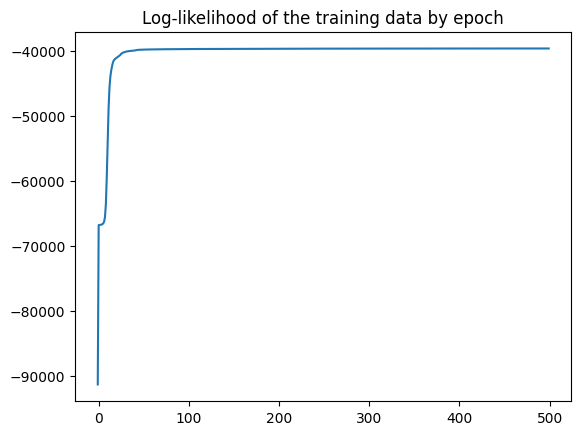

——————————[ Running experiment for seed 43 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -38998.29857538698 (AVG: -8.138209218569903)


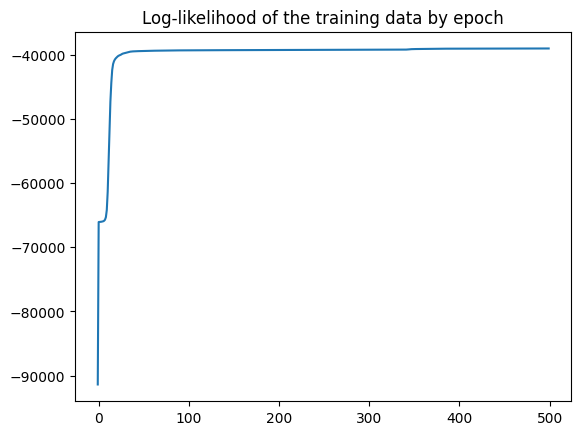

——————————[ Running experiment for seed 44 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -38351.08781789531 (AVG: -8.003148542966468)


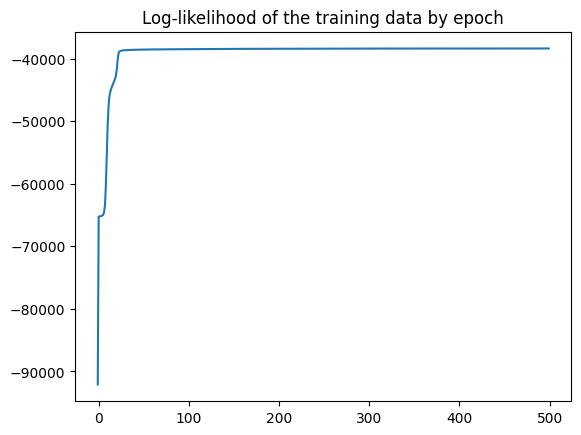

——————————[ Running experiment for seed 45 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -37409.427741554464 (AVG: -7.806641849239245)


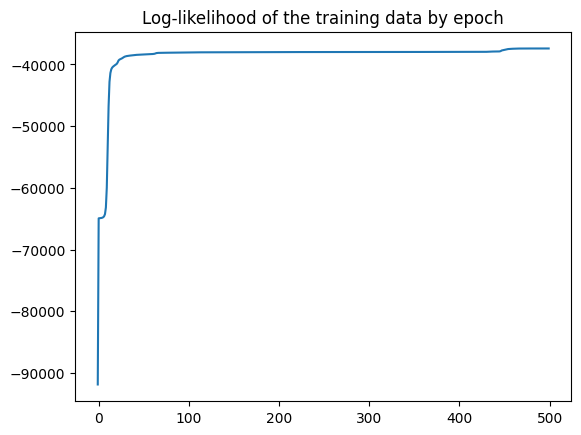

——————————[ Running experiment for seed 46 ]——————————
Training IoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -36173.33141952039 (AVG: -7.548691865509264)


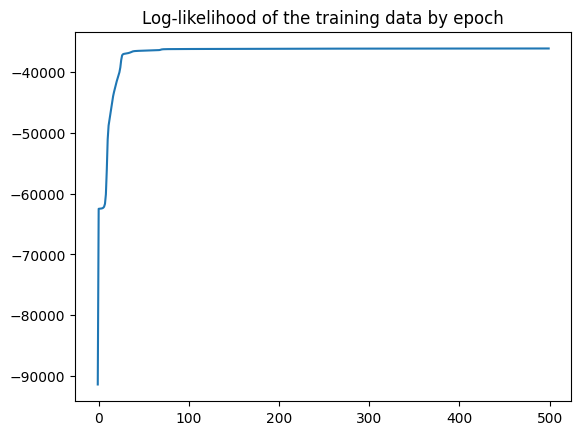

In [10]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    iohmm_rspn = IoHmmRSPN.construct_randomized(num_inputs, NUM_STATES, num_observations, seed)
    train_data = train_vaso_datasets[i].spn_data_discrete
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_vaso_datasets[i].spn_data_discrete).mean()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [11]:
print("——————————[ IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ IOHMM-RSPN log-likelihood ]——————————
Mean: -8.195623840753878
STD: 1.3397668610115503
All: [-6.587486773011793, -7.090903286593485, -8.308490071668857, -8.553375545763313, -10.43786352673195]
Median seed: 44


In [12]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = evaluate_rspn_one_step_ahead_prediction(iohmm_rspn_models[i], test_vaso_datasets[i], [2], 2, identifier=f"seed {seed}")
    add_metrics(aggregate_metrics, metrics)

——————————[ Running classification evaluation for seed 42 ]——————————
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2383
           1       0.83      0.83      0.83      1407
           2       0.80      0.78      0.79       362
           3       0.80      0.89      0.85       101
           4       0.47      0.47      0.47       625
           5       0.42      0.38      0.40       387
           6       0.51      0.41      0.46       134
           7       0.00      0.00      0.00        18
           8       0.48      0.40      0.43       263
           9       0.51      0.46      0.48       217
          10       0.52      0.46      0.49        74
          11       0.33      0.16      0.21        19

    accuracy                           0.73      5990
   macro avg       0.54      0.51      0.52      5990
weighted avg       0.72      0.73      0.73      5990

AUROC (macro): 0.9476926425177566
AUROC (weighted): 0.937085454

In [13]:
print("——————————[ IOHMM-RSPN classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

——————————[ IOHMM-RSPN classification performance ]——————————
accuracy: 0.6176627712854759 (SD 0.07928174141474438)
original brier: 0.5151258950305488 (SD 0.0837349085556362)
precision (macro avg): 0.48483500739853785 (SD 0.047763834810319435)
recall (macro avg): 0.47119619646056227 (SD 0.034432206760610685)
f1-score (macro avg): 0.4486549893640507 (SD 0.05713865218889859)
auroc (macro avg): 0.9385286474591158 (SD 0.007946737662039611)
precision (weighted avg): 0.6101285028322211 (SD 0.07432817272726398)
recall (weighted avg): 0.6176627712854759 (SD 0.07928174141474438)
f1-score (weighted avg): 0.6036034913104944 (SD 0.08366863816045168)
auroc (weighted avg): 0.9199459548279613 (SD 0.014217702734486757)


### Overparametrised IOHMM-RSPN Vasopressors Classification Evaluation

——————————[ Running experiment for seed 42 ]——————————
Training OverparametrisedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -39593.30441817575 (AVG: -8.262375713308796)


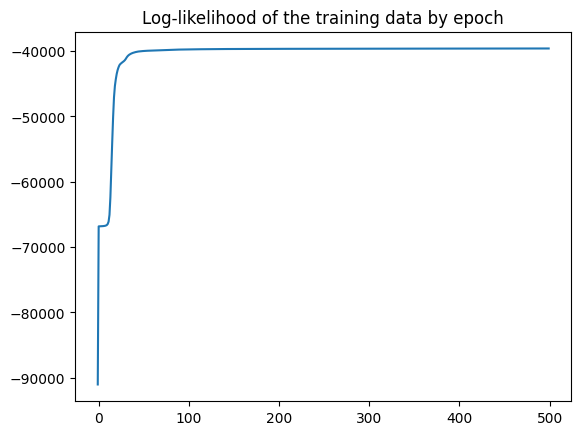

——————————[ Running experiment for seed 43 ]——————————
Training OverparametrisedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -39046.521247159544 (AVG: -8.148272380459003)


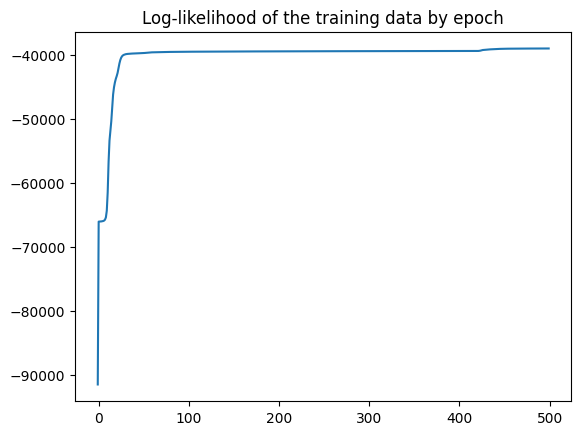

——————————[ Running experiment for seed 44 ]——————————
Training OverparametrisedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -38119.279099872 (AVG: -7.954774436534224)


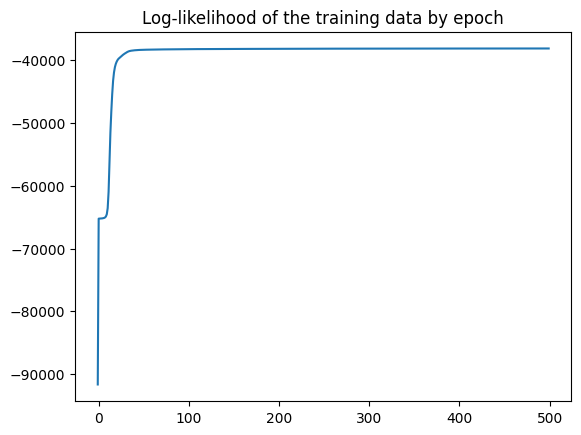

——————————[ Running experiment for seed 45 ]——————————
Training OverparametrisedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -37848.33887631261 (AVG: -7.898234323103634)


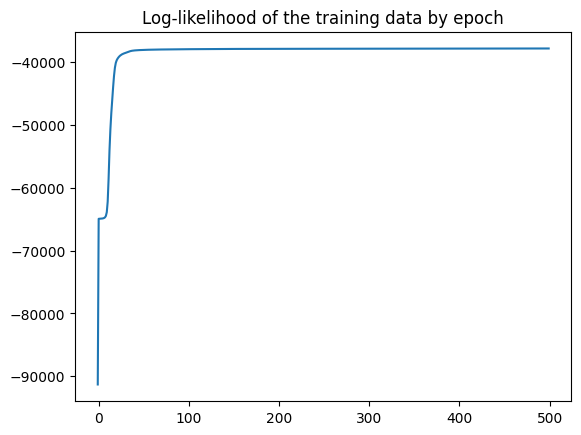

——————————[ Running experiment for seed 46 ]——————————
Training OverparametrisedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -35388.2525871899 (AVG: -7.384860723537124)


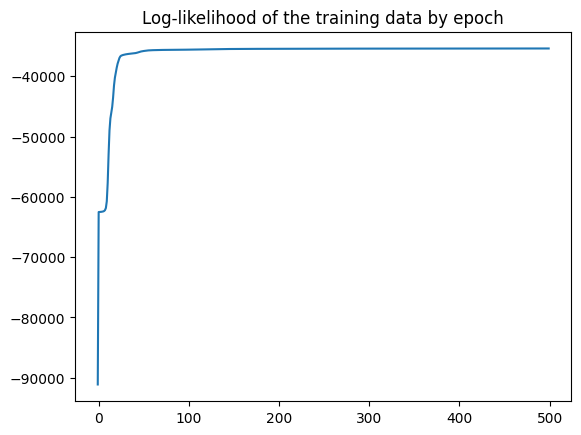

In [14]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    iohmm_rspn = OverparametrisedIoHmmRSPN.construct_randomized(num_inputs, NUM_STATES, num_observations, seed)
    train_data = train_vaso_datasets[i].spn_data_discrete
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_vaso_datasets[i].spn_data_discrete).mean()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [15]:
print("——————————[ Overparametrised IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Overparametrised IOHMM-RSPN log-likelihood ]——————————
Mean: -8.173240141222184
STD: 1.2795060583214373
All: [-6.590313888226378, -7.099123870401563, -8.294720499317373, -8.63572554694926, -10.246316901216346]
Median seed: 44


In [16]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = evaluate_rspn_one_step_ahead_prediction(iohmm_rspn_models[i], test_vaso_datasets[i], [2], 2, identifier=f"seed {seed}")
    add_metrics(aggregate_metrics, metrics)

——————————[ Running classification evaluation for seed 42 ]——————————
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2383
           1       0.83      0.83      0.83      1407
           2       0.80      0.76      0.78       362
           3       0.81      0.90      0.85       101
           4       0.48      0.44      0.46       625
           5       0.41      0.38      0.40       387
           6       0.50      0.45      0.47       134
           7       0.00      0.00      0.00        18
           8       0.48      0.42      0.45       263
           9       0.50      0.45      0.47       217
          10       0.54      0.45      0.49        74
          11       0.38      0.16      0.22        19

    accuracy                           0.73      5990
   macro avg       0.55      0.51      0.52      5990
weighted avg       0.72      0.73      0.73      5990

AUROC (macro): 0.9480952941977664
AUROC (weighted): 0.937345204

In [17]:
print("——————————[ Overparametrised IOHMM-RSPN classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

——————————[ Overparametrised IOHMM-RSPN classification performance ]——————————
accuracy: 0.6218030050083473 (SD 0.07645527096030068)
original brier: 0.5123984529332305 (SD 0.08172697706133637)
precision (macro avg): 0.48311095762515865 (SD 0.03535719283954104)
recall (macro avg): 0.48412510156216576 (SD 0.03275303780483873)
f1-score (macro avg): 0.4657093941188973 (SD 0.045689094318583444)
auroc (macro avg): 0.9394228489469139 (SD 0.006875444320311291)
precision (weighted avg): 0.6103153425477001 (SD 0.07064630355982204)
recall (weighted avg): 0.6218030050083473 (SD 0.07645527096030068)
f1-score (weighted avg): 0.6091589708516715 (SD 0.07835925921580934)
auroc (weighted avg): 0.9203956571515395 (SD 0.013970805064204455)


### LSTM Vasopressors Classification Evaluation

In [ ]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = train_eval_lstm(
        train_vaso_datasets[i], 
        test_vaso_datasets[i],
        num_inputs,
        num_observations,
        seed
    )
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ LSTM classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

### Most Common Class Baseline Vasopressors Classification Evaluation

In [ ]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = train_eval_most_common_baseline(
        train_vaso_datasets[i], 
        test_vaso_datasets[i],
        2,
        identifier=f"seed {seed}"
    )
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ Most common class classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

# IOHMM Action Prediction

## Extended IOHMM-RSPN Vasopressors Action Prediction

——————————[ Running experiment for seed 42 ]——————————
Training ExtendedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


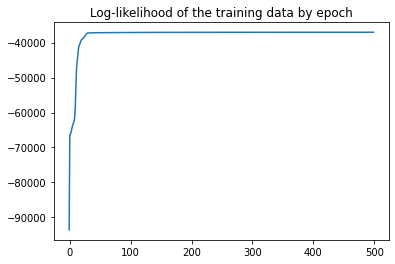

——————————[ Running experiment for seed 43 ]——————————
Training ExtendedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


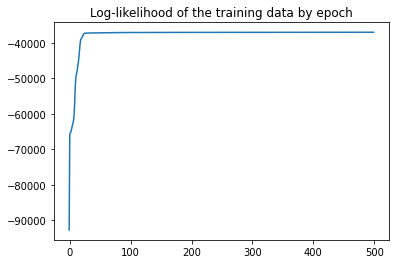

——————————[ Running experiment for seed 44 ]——————————
Training ExtendedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


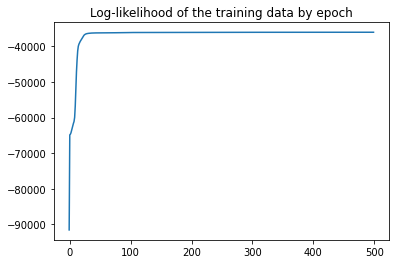

——————————[ Running experiment for seed 45 ]——————————
Training ExtendedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


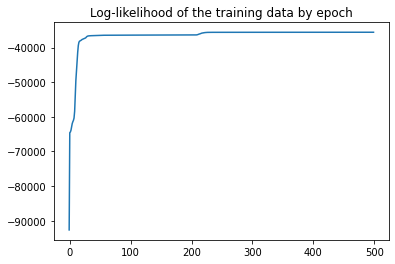

——————————[ Running experiment for seed 46 ]——————————
Training ExtendedIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


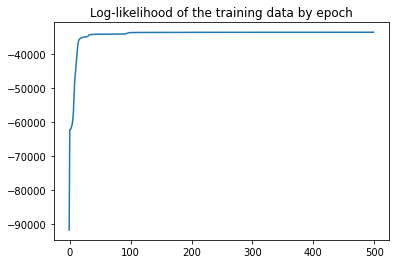

In [3]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    iohmm_rspn = ExtendedIoHmmRSPN.construct_randomized(num_inputs, NUM_STATES, num_observations, seed)
    train_data = train_vaso_datasets[i].spn_data_discrete
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_vaso_datasets[i].spn_data_discrete).sum()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [4]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/discrete_io_hmm_rspn_action_pred_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

In [5]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/discrete_io_hmm_rspn_action_pred_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

In [6]:
print("——————————[ Extended IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

In [ ]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = evaluate_rspn_one_step_ahead_prediction(iohmm_rspn_loaded_models[i], test_vaso_datasets[i], [0, 2], 0, identifier=f"seed {seed}")
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ Extended IOHMM-RSPN classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

## LSTM Vasopressors Action Prediction

——————————[ Running LSTM classification evaluation for seed 42 ]——————————
Training LSTM...
150


  0%|          | 0/30 [00:00<?, ?it/s]

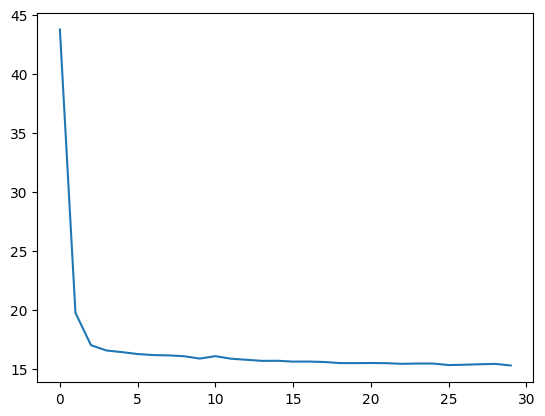

Training complete.
Evaluating...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4667
           1       0.89      0.55      0.68       129

    accuracy                           0.99      4796
   macro avg       0.94      0.77      0.84      4796
weighted avg       0.99      0.99      0.98      4796

AUROC (macro): 0.8987970958884995
AUROC (weighted): 0.8987970958884995
Original Brier: 0.026644206654596013
——————————[ Running LSTM classification evaluation for seed 43 ]——————————
Training LSTM...
150


  0%|          | 0/30 [00:00<?, ?it/s]

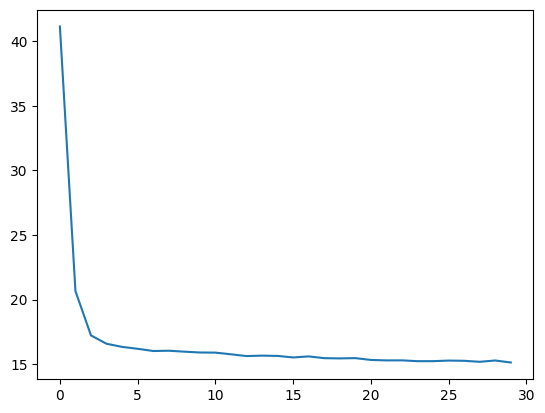

Training complete.
Evaluating...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4641
           1       0.91      0.58      0.71       155

    accuracy                           0.98      4796
   macro avg       0.95      0.79      0.85      4796
weighted avg       0.98      0.98      0.98      4796

AUROC (macro): 0.9128802885918634
AUROC (weighted): 0.9128802885918634
Original Brier: 0.029014698914943984
——————————[ Running LSTM classification evaluation for seed 44 ]——————————
Training LSTM...
150


  0%|          | 0/30 [00:00<?, ?it/s]

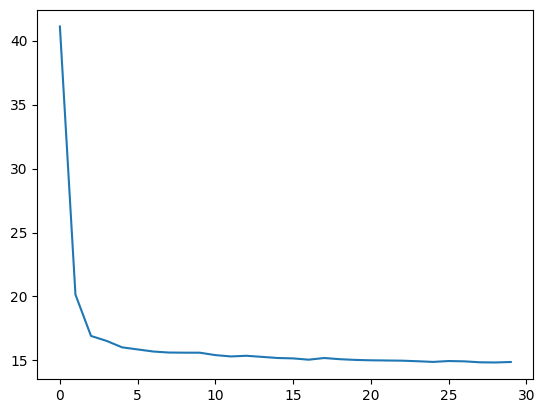

Training complete.
Evaluating...
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4607
           1       0.98      0.61      0.75       185

    accuracy                           0.98      4792
   macro avg       0.98      0.81      0.87      4792
weighted avg       0.98      0.98      0.98      4792

AUROC (macro): 0.9106048961920461
AUROC (weighted): 0.9106048961920461
Original Brier: 0.03122533068765628
——————————[ Running LSTM classification evaluation for seed 45 ]——————————
Training LSTM...
150


  0%|          | 0/30 [00:00<?, ?it/s]

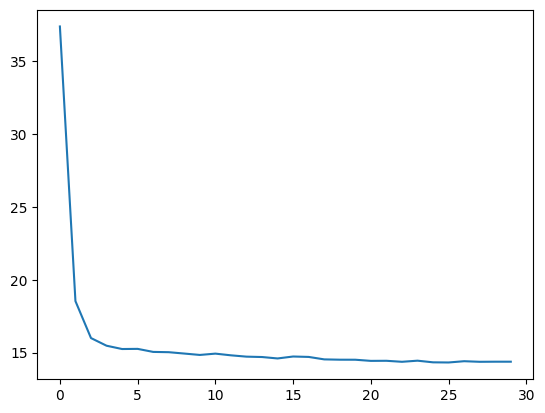

Training complete.
Evaluating...
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4594
           1       0.89      0.60      0.71       198

    accuracy                           0.98      4792
   macro avg       0.94      0.80      0.85      4792
weighted avg       0.98      0.98      0.98      4792

AUROC (macro): 0.8834612999828497
AUROC (weighted): 0.8834612999828497
Original Brier: 0.038018785576541723
——————————[ Running LSTM classification evaluation for seed 46 ]——————————
Training LSTM...
150


  0%|          | 0/30 [00:00<?, ?it/s]

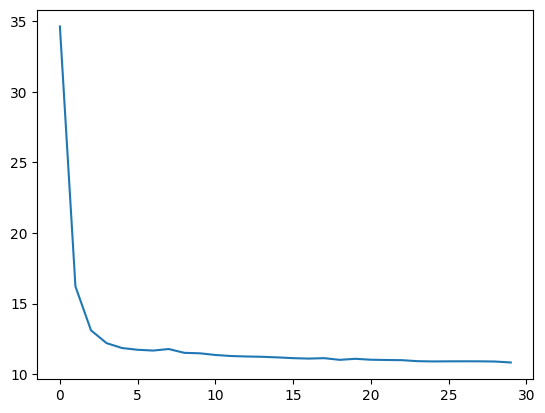

Training complete.
Evaluating...
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4233
           1       0.95      0.64      0.76       559

    accuracy                           0.95      4792
   macro avg       0.95      0.82      0.87      4792
weighted avg       0.95      0.95      0.95      4792

AUROC (macro): 0.8791165926464989
AUROC (weighted): 0.8791165926464989
Original Brier: 0.08822464499837791


In [21]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = train_eval_lstm(
        train_vaso_datasets[i], 
        test_vaso_datasets[i],
        num_inputs,
        num_observations,
        seed,
        action_prediction=True,
    )
    add_metrics(aggregate_metrics, metrics)

In [22]:
print("——————————[ LSTM classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

——————————[ LSTM classification performance ]——————————
accuracy: 0.9777594990817334 (SD 0.012305342412139677)
original brier: 0.042625533366423184 (SD 0.02311330069841062)
precision (macro avg): 0.9508554228703646 (SD 0.017376007193160445)
recall (macro avg): 0.796236298272022 (SD 0.014177024287712062)
f1-score (macro avg): 0.8556822697946884 (SD 0.013159718520550805)
auroc (macro avg): 0.8969720346603516 (SD 0.013737649480272923)
precision (weighted avg): 0.9770543953250698 (SD 0.012130828832579783)
recall (weighted avg): 0.9777594990817334 (SD 0.012305342412139677)
f1-score (weighted avg): 0.9755719369358656 (SD 0.013244683800335673)
auroc (weighted avg): 0.8969720346603516 (SD 0.013737649480272923)


## Most Common Class Baseline Vasopressors Action Prediction Evaluation

In [ ]:
aggregate_metrics = get_empty_metrics()
for i, seed in enumerate(SEEDS):
    _, _, _, metrics = train_eval_most_common_baseline(
        train_vaso_datasets[i], 
        test_vaso_datasets[i],
        0,
        identifier=f"seed {seed}"
    )
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ Most common class classification performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

# Continuous IOHMM Experiments

## Reference IOHMM-RSPN

In [4]:
reference_io_hmm_rspn = create_continuous_engine_iohmm()

In [5]:
log_likelihoods = []
for i in range(len(SEEDS)):
    print(f"——————————[ Computing reference IOHMM-RSPN likelihood for partition {i} ]——————————")
    data_log_likelihood = log_likelihood(reference_io_hmm_rspn.unroll(SEQ_LENGTH), test_engine_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

——————————[ Computing reference IOHMM-RSPN likelihood for partition 0 ]——————————
——————————[ Computing reference IOHMM-RSPN likelihood for partition 1 ]——————————
——————————[ Computing reference IOHMM-RSPN likelihood for partition 2 ]——————————
——————————[ Computing reference IOHMM-RSPN likelihood for partition 3 ]——————————
——————————[ Computing reference IOHMM-RSPN likelihood for partition 4 ]——————————


In [6]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -79488.66699129755
STD: 104.77228795292588
All: [-79485.73887055033, -79472.17826584243, -79441.83913187053, -79363.33007375276, -79680.24861447175]
Median seed: 43


## Continuous IOHMM-RSPN training sanity check
Trains an IOHMM-RSPN initialized with the ground truth parameters for the engine dataset - parameters should remain relatively stable during training.

——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -79728.3401257075 (AVG: -79.7283401257075)


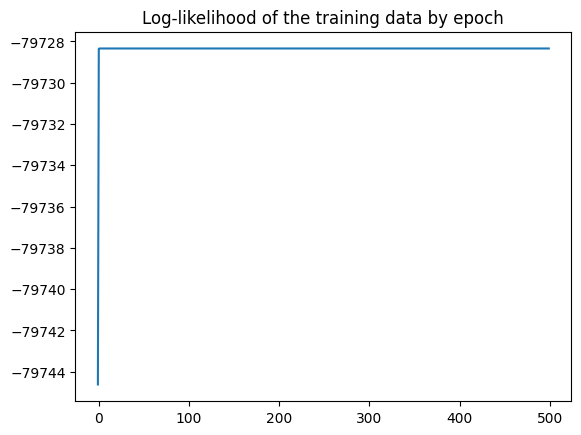

——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -79309.75415468105 (AVG: -79.30975415468106)


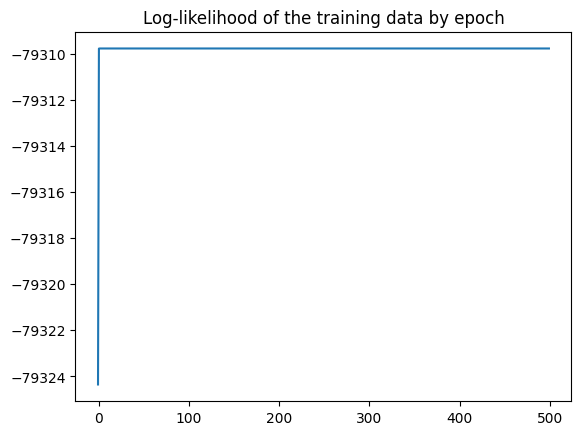

——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -79235.66807738936 (AVG: -79.23566807738936)


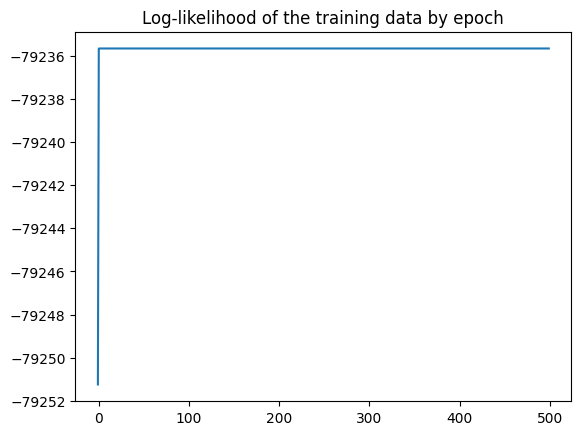

——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -79460.6522446331 (AVG: -79.4606522446331)


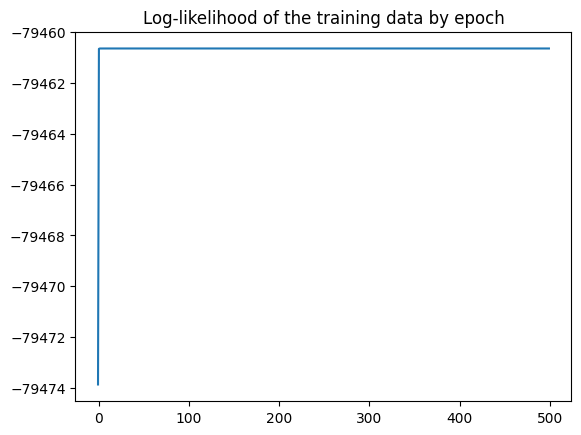

——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -79397.73133548463 (AVG: -79.39773133548462)


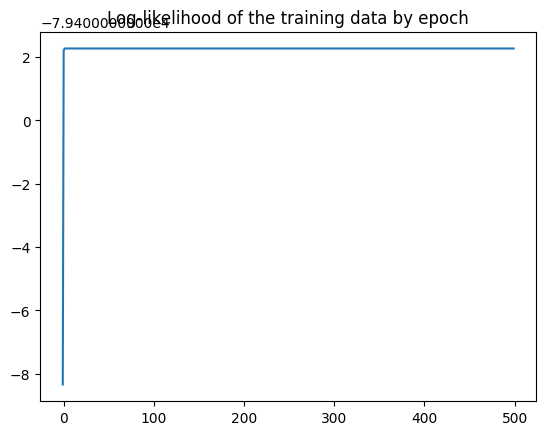

In [7]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    iohmm_rspn = create_continuous_engine_iohmm()
    train_data = train_engine_datasets[i].spn_data_continuous
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_engine_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [8]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -79503.3710516789
STD: 102.70080962468175
All: [-79509.06429747914, -79483.34142001192, -79463.19042411346, -79373.78067078808, -79687.47844600186]
Median seed: 43


## Continuous IOHMM-RSPN engine dataset training
Trains an IOHMM-RSPN initialized randomly with GMM-EM on the engine dataset. Should ideally yield likelihoods close to the likelihood of the reference IOHMM-RSPN model computed above.

In [29]:
(
    prior_proba,
    _,
    trans_proba,
    _,
    emission_means,
    _,
) = get_engine_parameters()
num_inputs = len(prior_proba)
num_states = len(trans_proba)
observations_dim = emission_means.shape[-1]

——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -80342.99732258153 (AVG: -80.34299732258154)


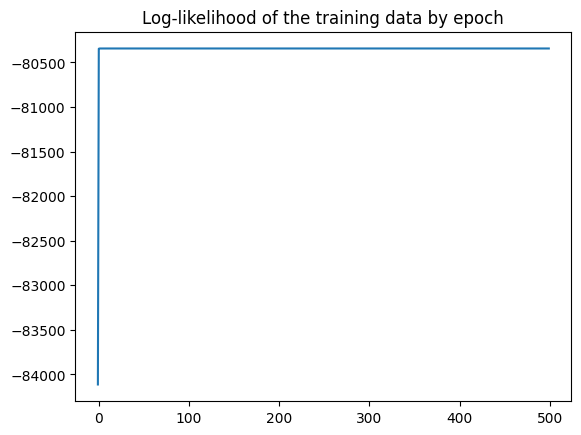

——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -79309.75419226899 (AVG: -79.30975419226898)


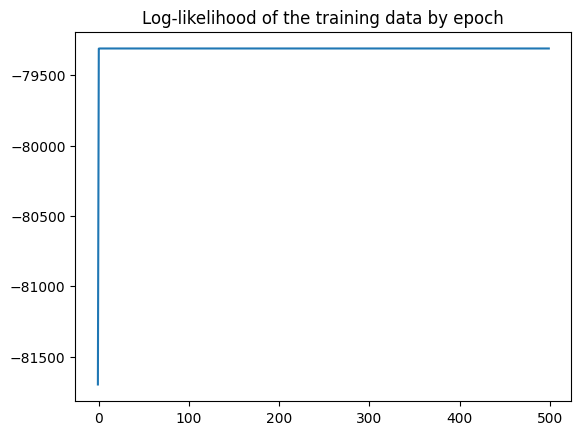

——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -79896.90816784004 (AVG: -79.89690816784004)


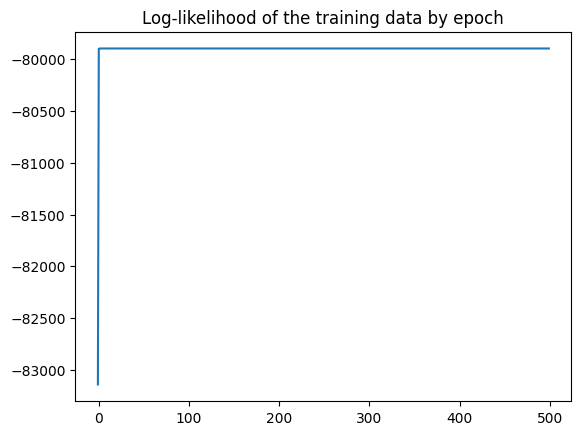

——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -80108.00256803111 (AVG: -80.10800256803111)


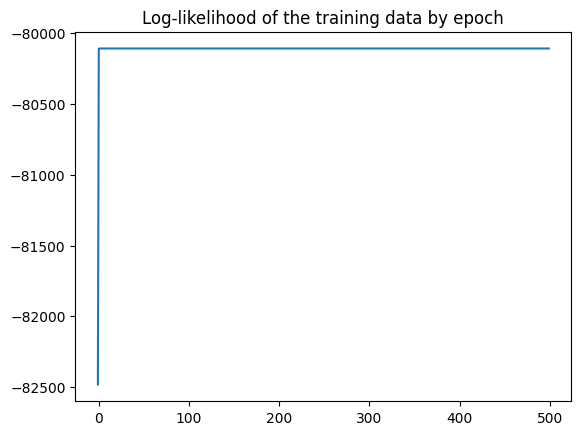

——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -80068.98386730156 (AVG: -80.06898386730157)


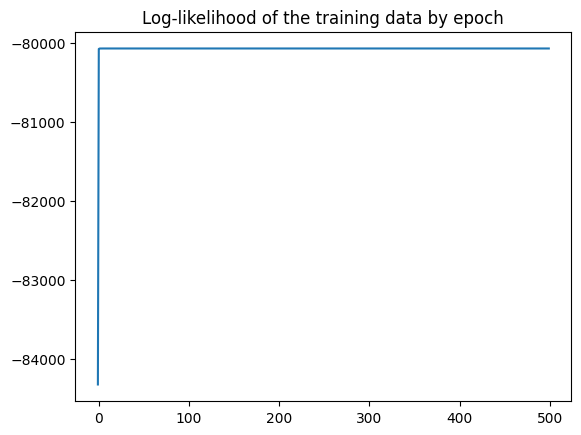

In [30]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    train_observations = train_engine_datasets[i].observations_raw_continuous
    train_inputs = train_engine_datasets[i].inputs_raw
    iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, num_states, observations_dim, seed)
    train_data = train_engine_datasets[i].spn_data_continuous
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_engine_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [31]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -80031.15615196021
STD: 302.01499865719484
All: [-80195.70606337633, -79483.34366345579, -80163.76273593522, -79956.61996762679, -80356.34832940696]
Median seed: 44


## Continuous IOHMM-RSPN structure learning on synthetic data
Trains an IOHMM-RSPN with structure learning on a synthetic dataset.

In [19]:
StructureDataset = namedtuple(
    "StructureDataset",
    [
        "inputs_raw",
        "states_raw",
        "observations_raw_continuous",
        "spn_data_continuous",
        "log_likelihood",
    ],
)

In [40]:
def generate_structure_dataset(num_samples=1000, seq_length=12):
    # Specify data generation parameters
    prior_proba = [0.7, 0.3]
    start_proba = [[0.7, 0.3], [0.1, 0.9]]
    trans_proba = [
        [[0.9, 0.1], [0.5, 0.5]],
        [[0.6, 0.4], [0.1, 0.9]]
    ]
    cluster_proba = [
        [[0.7, 0.1, 0.2], [0.1, 0.9, 0.0]],
        [[0.1, 0.9, 0.0], [0.7, 0.1, 0.2]]
    ]
    emission_means = [
        [
            [[-15, -5], [-15, 5], [-22, 0]],
            [[5, -5], [5, 5], [0, 0]]
        ],
        [
            [[-5, -5], [-5, 5], [0, 0]],
            [[15, -5], [15, 5], [22, 0]]
        ],
    ]
    emission_covars = [
        [
            [[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]],
            [[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]],
        ],
        [
            [[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]],
            [[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]],
        ]
    ]
    prior_proba = torch.tensor(prior_proba, dtype=torch.float64)
    start_proba = torch.tensor(start_proba, dtype=torch.float64)
    trans_proba = torch.tensor(trans_proba, dtype=torch.float64)
    cluster_proba = torch.tensor(cluster_proba, dtype=torch.float64)
    emission_means = torch.tensor(emission_means, dtype=torch.float64)
    emission_covars = torch.tensor(emission_covars, dtype=torch.float64)
    num_continuous_observations = emission_means.shape[-1]

    inputs_raw = []
    states_raw = []
    observations_raw_continuous = []
    prior_dist = torch.distributions.Categorical(prior_proba)
    sample_log_probs = []
    for _ in range(num_samples):
        sample_log_prob = 0
        prev_state = None
        inputs_raw_sample = []
        states_raw_sample = []
        observations_raw_continuous_sample = []
        
        for _ in range(seq_length):
            current_input = prior_dist.sample().item()
            sample_log_prob += prior_dist.log_prob(torch.tensor(current_input))
            inputs_raw_sample.append(current_input)
            if prev_state is None:
                state_dist = torch.distributions.Categorical(
                    start_proba[current_input]
                )
            else:
                state_dist = torch.distributions.Categorical(
                    trans_proba[prev_state][current_input]
                )
            current_state = state_dist.sample().item()
            sample_log_prob += state_dist.log_prob(torch.tensor(current_state))
            states_raw_sample.append(current_state)
            prev_state = current_state
            cluster_dist = torch.distributions.Categorical(
                cluster_proba[current_input][current_state]
            )
            current_cluster = cluster_dist.sample().item()
            sample_log_prob += cluster_dist.log_prob(torch.tensor(current_cluster))
            obs_dist = torch.distributions.MultivariateNormal(
                emission_means[current_input][current_state][current_cluster],
                covariance_matrix=emission_covars[current_input][current_state][current_cluster],
            )
            current_obs = obs_dist.sample().tolist()
            sample_log_prob += obs_dist.log_prob(torch.tensor(current_obs))
            observations_raw_continuous_sample.append(current_obs)
        
        inputs_raw.append(inputs_raw_sample)
        states_raw.append(states_raw_sample)
        observations_raw_continuous.append(observations_raw_continuous_sample)
        sample_log_probs.append(sample_log_prob)

    observations_raw_continuous = np.array(observations_raw_continuous)
    spn_data_continuous = np.full(
        (num_samples, (2 + num_continuous_observations) * seq_length), np.nan
    )
    spn_data_continuous[:, 0 :: 2 + num_continuous_observations] = np.array(
        inputs_raw
    ).reshape(num_samples, seq_length)
    for i in range(num_continuous_observations):
        spn_data_continuous[:, 2 + i :: 2 + num_continuous_observations] = np.array(
            observations_raw_continuous[:, :, i]
        )
        
    total_log_likelihood = sum(sample_log_probs).item()

    return StructureDataset(
        inputs_raw=np.array(inputs_raw),
        states_raw=np.array(states_raw),
        observations_raw_continuous=observations_raw_continuous,
        spn_data_continuous=spn_data_continuous,
        log_likelihood=total_log_likelihood
    )

In [41]:
# TODO: Refactor
def generate_structure_datasets(
    seeds=range(42, 42 + 5), development_samples=1000, test_samples=1000, seq_length=12
):
    """
    Generates structure datasets with the specified number of seed partitions, samples and sequence lengths

    :param seeds: The seeds to use when generating partitions
    :param development_samples: The number of samples in the development set (to be used for training and validation)
    :param test_samples: The number of samples in the withheld test set
    :param seq_length: The length of the temporal sequences to generate
    """
    development_structure_datasets = []
    test_structure_datasets = []

    for seed in seeds:
        torch.manual_seed(seed)
        development_structure_dataset = generate_structure_dataset(
            num_samples=development_samples, seq_length=seq_length
        )
        development_structure_datasets.append(development_structure_dataset)
        test_structure_dataset = generate_structure_dataset(
            num_samples=test_samples, seq_length=seq_length
        )
        test_structure_datasets.append(test_structure_dataset)

    return development_structure_datasets, test_structure_datasets

In [42]:
NUM_SEEDS = 5
TRAIN_SAMPLES = 1000
TEST_SAMPLES = 1000
SEQ_LENGTH = 12
SEEDS = range(42, 42 + NUM_SEEDS)

train_structure_datasets, test_structure_datasets = generate_structure_datasets(
    seeds=SEEDS,
    development_samples=TRAIN_SAMPLES,
    test_samples=TEST_SAMPLES,
    seq_length=SEQ_LENGTH,
)
observations_dim = len(train_structure_datasets[0].observations_raw_continuous[0][0])
num_inputs = (
    int(
        np.max(train_structure_datasets[0].inputs_raw)
    )
    + 1
)
num_states = (
    int(
        np.max(train_structure_datasets[0].states_raw)
    )
    + 1
)

In [43]:
log_likelihoods = []
for dataset in test_structure_datasets:
    log_likelihoods.append(dataset.log_likelihood)

print("——————————[ Ground-truth model data likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Ground-truth model data likelihood ]——————————
Mean: -55364.68073181305
STD: 143.07238912953235
All: [-55484.309561379334, -55281.2900512787, -55290.37842061451, -55190.27263283725, -55577.152992955496]
Median seed: 44


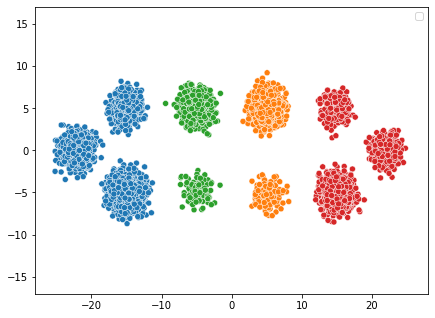

In [7]:
%matplotlib inline
plot_data = train_structure_datasets[0].observations_raw_continuous.reshape((-1, 2))
inputs_flattened = np.array(train_structure_datasets[0].inputs_raw).reshape(-1)
states_flattened = np.array(train_structure_datasets[0].states_raw).reshape(-1)
hues = [f"Input {i}, State {s}" for i, s in zip(inputs_flattened, states_flattened)]
ax = sns.scatterplot(x=plot_data[:, 0], y=plot_data[:, 1], hue=hues)
ax.set(ylim=(-17, 17), xlim=(-28, 28))
fig = plt.gcf()
fig.set_size_inches(7.04, 5.28)
# plt.legend(loc="lower center", prop={'size': 9})
plt.legend([], [])
plt.savefig(f"plots/Structure-Synthetic-Dataset.png", format="png", dpi=300)

### Regular IOHMM-RSPN Learning

——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


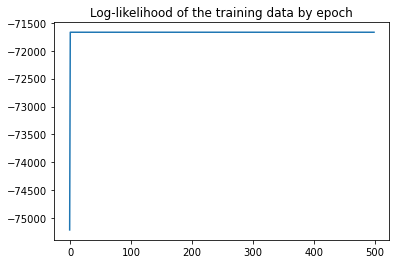

——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


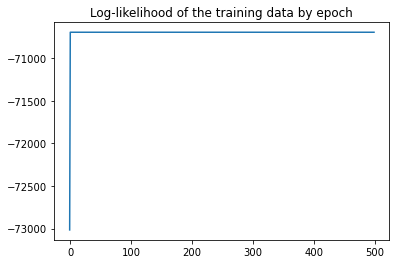

——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


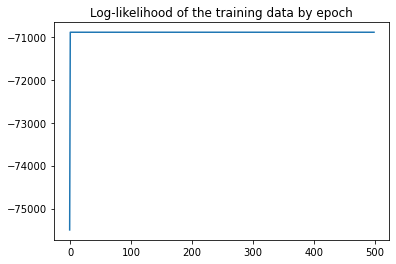

——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


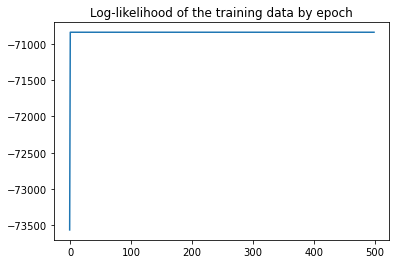

——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


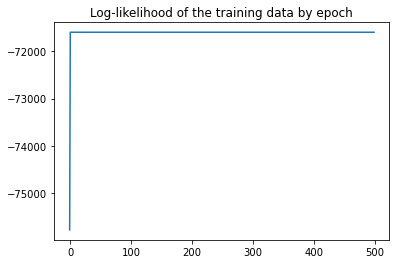

In [8]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    train_observations = train_structure_datasets[i].observations_raw_continuous
    train_inputs = train_structure_datasets[i].inputs_raw
    iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, num_states, observations_dim, seed)
    train_data = train_structure_datasets[i].spn_data_continuous
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_structure_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [9]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -70967.93857139537
STD: 460.4798386862636
All: [-71553.06249759886, -70593.38273378309, -70534.70475874, -70652.03334060739, -71506.50952624746]
Median seed: 45


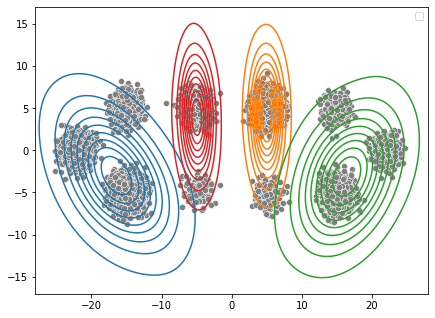

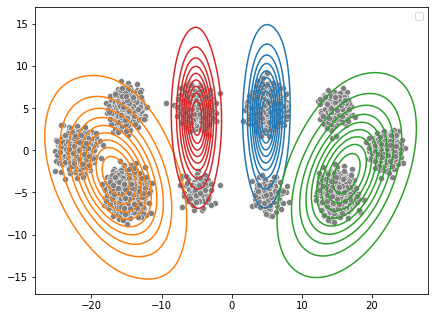

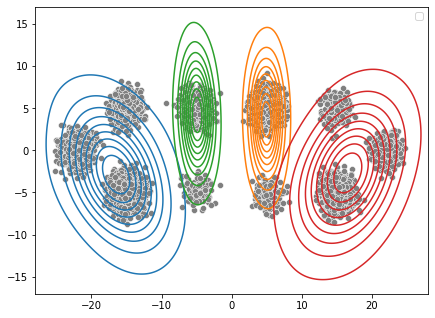

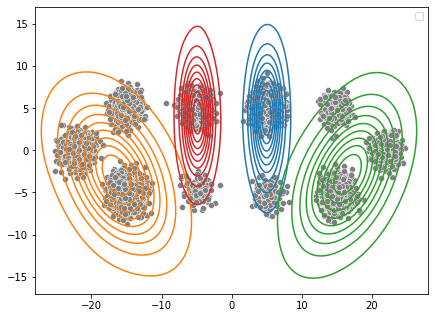

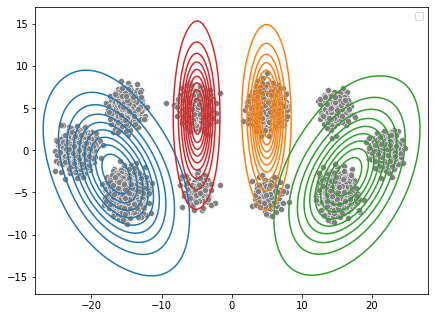

In [10]:
def plot_gaussians(gaussian_spns, i, color=None):
    plt.figure()
    ax = sns.scatterplot(x=plot_data[:, 0], y=plot_data[:, 1], color=sns.color_palette()[7], label="_nolegend_")
    ax.set(ylim=(-17, 17), xlim=(-28, 28))
    for gaussian_spn in gaussian_spns:
        x, y = np.mgrid[-30:30:.1, -10:10:.1]
        data = np.random.multivariate_normal(gaussian_spn.mean, gaussian_spn.sigma, size=1000)
        dframe = pd.DataFrame(data, columns=['x', 'y'])
        sns.kdeplot(data=dframe, bw=1, x='x', y='y')
    fig = plt.gcf()
    fig.set_size_inches(7.04, 5.28)
    # plt.legend(labels=["Input 0, State 0", "Input 0, State 1", "Input 1, State 0", "Input 1, State 1"], loc="lower center", prop={'size': 9})
    ax.set(xlabel=None, ylabel=None)
    plt.legend([], [])
    plt.savefig(f"plots/Structure-Synhetic-Data-Regular-Learning-{i}.png", format="png", dpi=300)
    plt.show()

for i in range(len(iohmm_rspn_models)):
    emission_spns = RSPN.retrieve_params(iohmm_rspn_models[i].unroll(2))['emission_spns']
    emission_spns = [item for sublist in emission_spns for item in sublist]
    plot_gaussians(emission_spns, i)

### Structure IOHMM-RSPN Learning

In [137]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=50,
    structure_learning_final_pause=100,
    num_epochs=500,
)

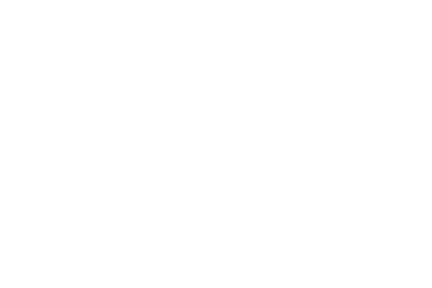

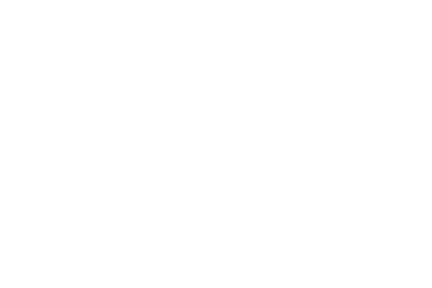

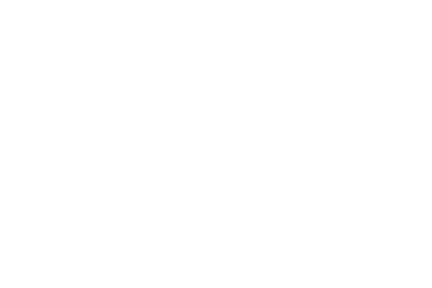

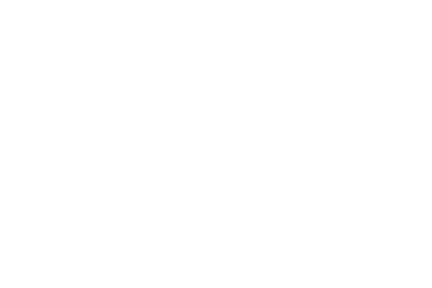

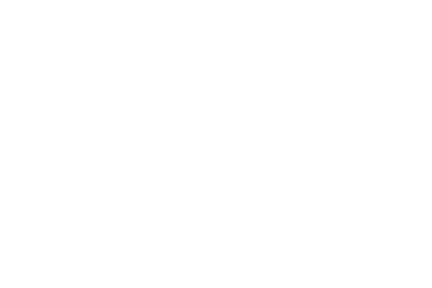

In [138]:
%matplotlib widget
live_figures = []
for seed in SEEDS:
    figure = plt.figure()
    live_figures.append(figure)

——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


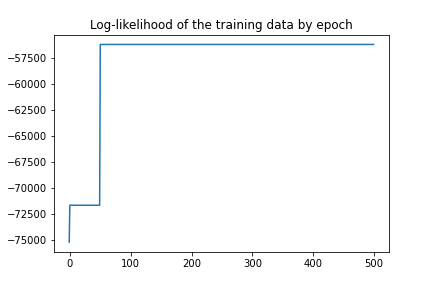

——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


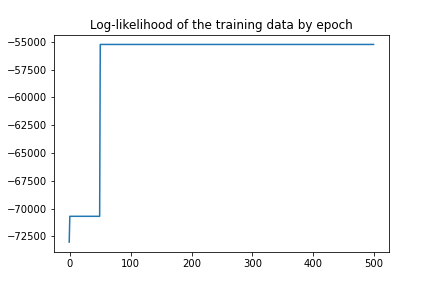

——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


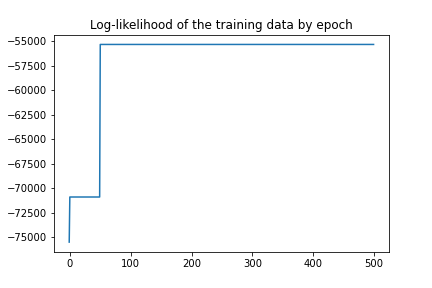

——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


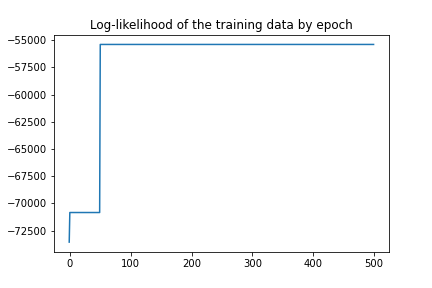

——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


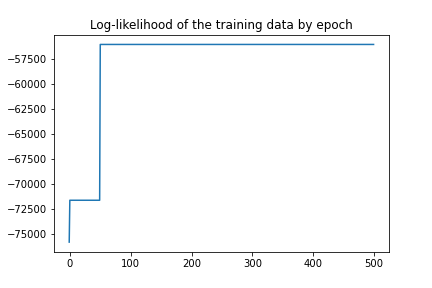

In [140]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    train_observations = train_structure_datasets[i].observations_raw_continuous
    train_inputs = train_structure_datasets[i].inputs_raw
    iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, num_states, observations_dim, seed)
    train_data = train_structure_datasets[i].spn_data_continuous
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params, plot_identifier=seed, live_figure=live_figures[i])
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_structure_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [142]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -55683.97328819544
STD: 486.2846121090756
All: [-56248.689558632184, -55312.17376055074, -55331.41409592762, -55221.49227933676, -56306.09674652994]
Median seed: 44


In [143]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_synthetic_structure_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

Press enter to continue


Ok, models saved


In [11]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_synthetic_structure_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

Ok, models loaded


In [12]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_structure_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -55683.97328819544
STD: 486.2846121090756
All: [-56248.689558632184, -55312.17376055074, -55331.41409592762, -55221.49227933676, -56306.09674652994]
Median seed: 44


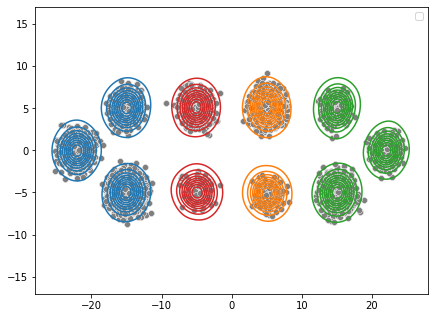

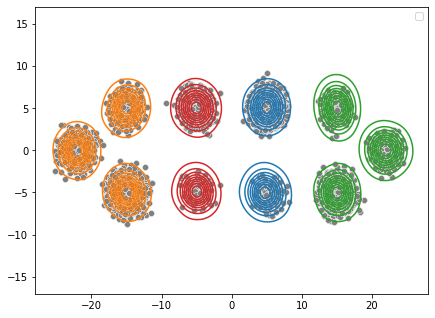

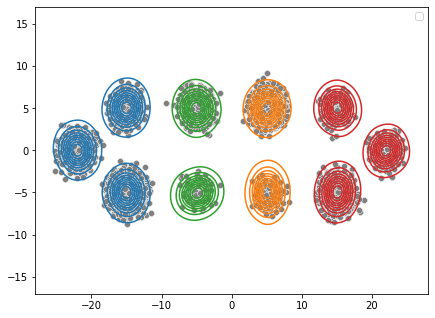

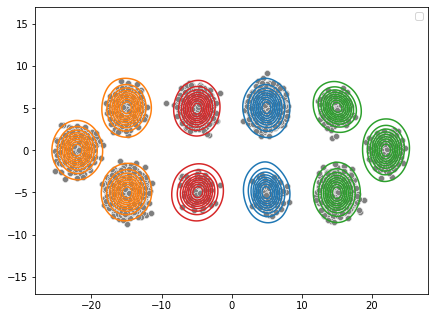

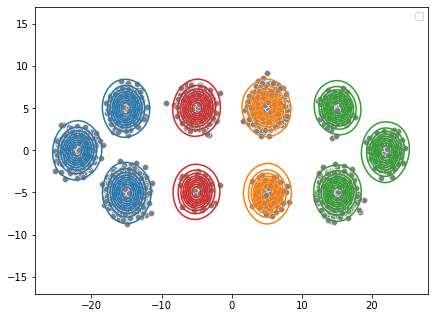

In [13]:
%matplotlib inline
def plot_structure_gaussians(gaussian_spns, i, color):
    ax = sns.scatterplot(x=plot_data[:, 0], y=plot_data[:, 1], color=sns.color_palette()[7], label="_nolegend_")
    ax.set(ylim=(-17, 17), xlim=(-28, 28))
    first = True
    for gaussian_spn in gaussian_spns:
        x, y = np.mgrid[-30:30:.1, -10:10:.1]
        data = np.random.multivariate_normal(gaussian_spn.mean, gaussian_spn.sigma, size=1000)
        dframe = pd.DataFrame(data, columns=['x', 'y'])
        if first:
            sns.kdeplot(data=dframe, bw=1, x='x', y='y', color=color)
            first = False
        else:
            sns.kdeplot(data=dframe, bw=1, x='x', y='y', color=color, label="_nolegend_")

for model_id, model in enumerate(iohmm_rspn_loaded_models):
    plt.figure()
    emission_spns = RSPN.retrieve_params(model.unroll(2))['emission_spns']
    color_idx = 0
    for i in range(num_inputs):
        for s in range(num_states):
            gaussian_spns = emission_spns[i][s].children
            plot_structure_gaussians(gaussian_spns, model_id, color=sns.color_palette()[color_idx])
            color_idx += 1
    fig = plt.gcf()
    fig.set_size_inches(7.04, 5.28)
    # plt.legend(labels=["Input 0, State 0", "Input 0, State 1", "Input 1, State 0", "Input 1, State 1"], loc="lower center", prop={'size': 9})
    plt.legend([], [])
    plt.gca().set(xlabel=None, ylabel=None)
    plt.savefig(f"plots/Structure-Synhetic-Data-Structure-Learning-{model_id}.png", format="png", dpi=300)
    plt.show()

# MIMIC Experiments

In [4]:
SEQ_LENGTH = 8
NUM_STATES = 20
NUM_SEEDS = 5
SEEDS = range(42, 42 + NUM_SEEDS)

train_mimic_datasets, test_mimic_datasets = load_mimic_dataset(
    seq_length=SEQ_LENGTH,
)
num_inputs = (
    int(
        np.max(train_mimic_datasets[0].inputs_raw)
    )
    + 1
)
observations_dim = 3

  0%|          | 0/6052 [00:00<?, ?it/s]

Loaded 5967 data points
Partitioning into folds...
Done!


In [5]:
import pickle
train_mimic_datasets, test_mimic_datasets = pickle.load(open('./data_splits/data.pkl', 'rb'))
observations_dim = 3
num_inputs = 2

<h2> oSLRAU  </h2>

## Continuous IOHMM-RSPN

——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


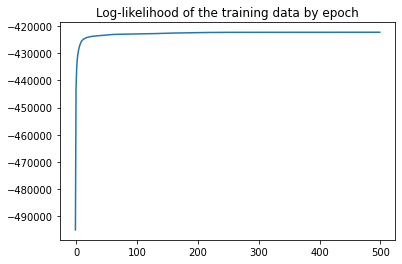

——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


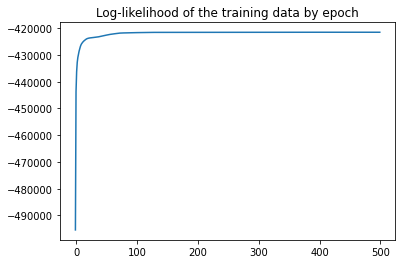

——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


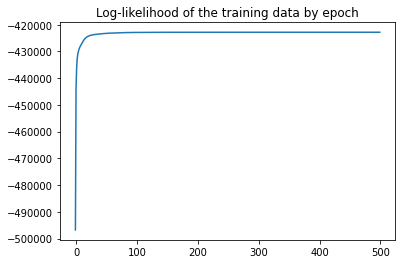

——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


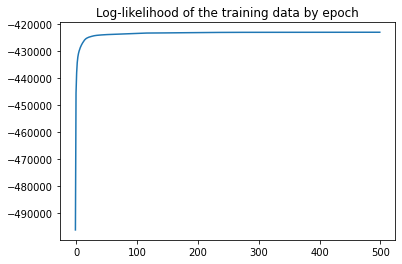

——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


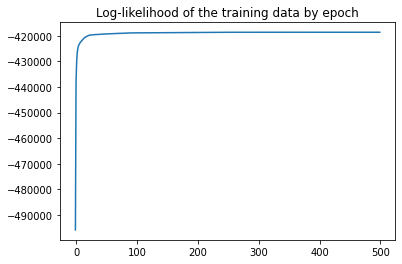

In [29]:
log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    train_observations = train_mimic_datasets[i].observations_raw_continuous
    train_inputs = train_mimic_datasets[i].inputs_raw
    iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, seed)
    train_data = train_mimic_datasets[i].spn_data_continuous
    optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, plot_identifier=seed)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [30]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_io_hmm_rspn_outcome_pred_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

In [31]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_io_hmm_rspn_outcome_pred_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

In [32]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -106765.52337642298
STD: 1876.2248934301335
All: [-106500.3834187034, -106944.82493398912, -105233.61484304193, -104943.48876015283, -110205.3049262277]
Median seed: 42


In [33]:
aggregate_metrics = get_empty_metrics(regression=True, num_variables=observations_dim)
for i, seed in enumerate(SEEDS):
    _, _, metrics = evaluate_rspn_observation_regression(iohmm_rspn_loaded_models[i], test_mimic_datasets[i], identifier=f"seed {seed}")
    add_metrics(aggregate_metrics, metrics)

——————————[ Running regression evaluation for seed 42 ]——————————
var 0: 10.12552654243609 (SD 0.0)
var 1: 13.362886290157988 (SD 0.0)
var 2: 4.523752258955472 (SD 0.0)
rmse: 9.33738836384985 (SD 0.0)
——————————[ Running regression evaluation for seed 43 ]——————————
var 0: 9.427844934555544 (SD 0.0)
var 1: 13.539828208973336 (SD 0.0)
var 2: 4.676513697749087 (SD 0.0)
rmse: 9.214728947092656 (SD 0.0)
——————————[ Running regression evaluation for seed 44 ]——————————
var 0: 9.568474313344089 (SD 0.0)
var 1: 12.202589845095687 (SD 0.0)
var 2: 4.480725749520501 (SD 0.0)
rmse: 8.75059663598676 (SD 0.0)
——————————[ Running regression evaluation for seed 45 ]——————————
var 0: 9.222288126339889 (SD 0.0)
var 1: 12.633730551518266 (SD 0.0)
var 2: 4.280542348186283 (SD 0.0)
rmse: 8.712187008681479 (SD 0.0)
——————————[ Running regression evaluation for seed 46 ]——————————
var 0: 9.77237665010283 (SD 0.0)
var 1: 13.616280121741475 (SD 0.0)
var 2: 4.556023984426515 (SD 0.0)
rmse: 9.314893585423606 (S

In [34]:
print("——————————[ IOHMM-RSPN regression performance ]——————————")
print_aggregate_metrics(aggregate_metrics)

——————————[ IOHMM-RSPN regression performance ]——————————
var 0: 9.623302113355688 (SD 0.3086986909115234)
var 1: 13.071063003497352 (SD 0.5563575567828637)
var 2: 4.503511607767573 (SD 0.1290979805071613)
rmse: 9.06595890820687 (SD 0.27654398095614297)


## Continuous Treatment-RSPN with Structure Learning

In [9]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=65,
    structure_learning_final_pause=100,
    num_epochs=500,
)

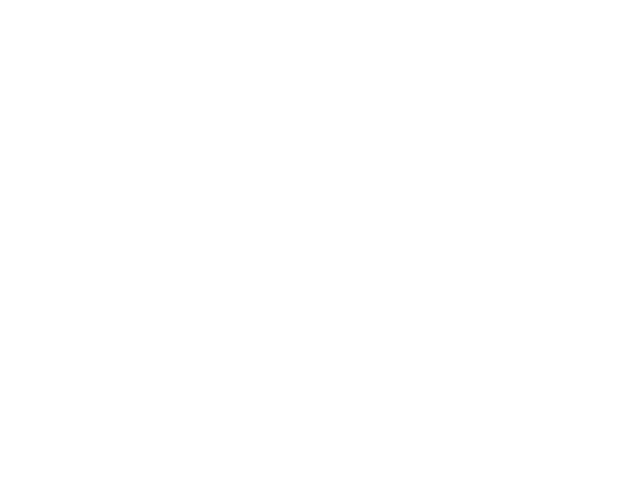

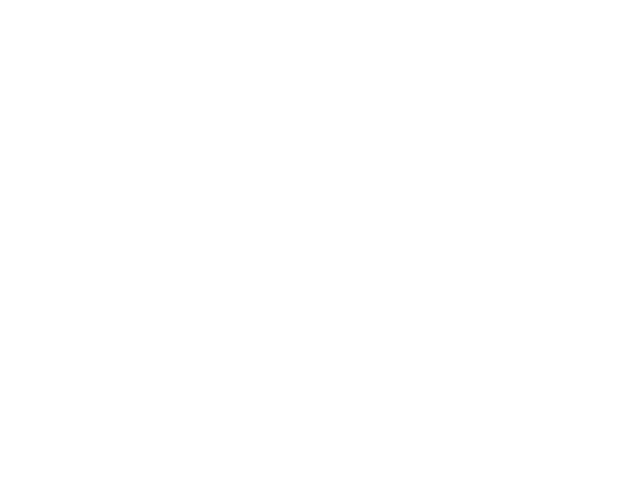

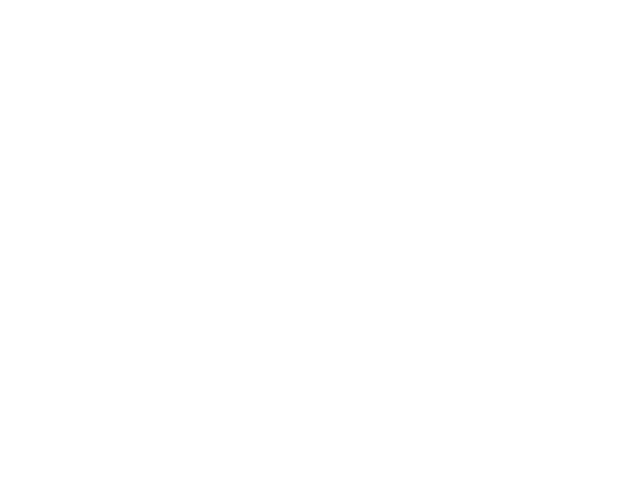

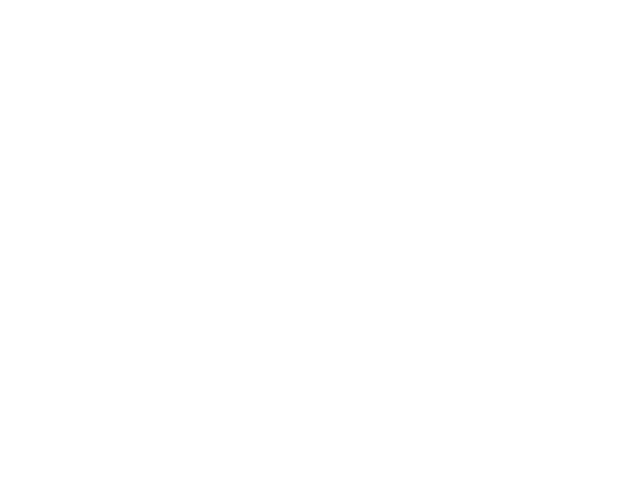

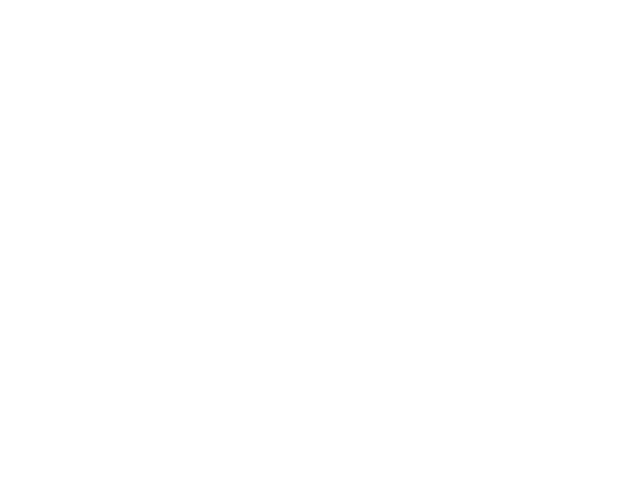

In [10]:
%matplotlib widget
live_figures = []
for seed in SEEDS:
    figure = plt.figure()
    live_figures.append(figure)

Press enter to continue


——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


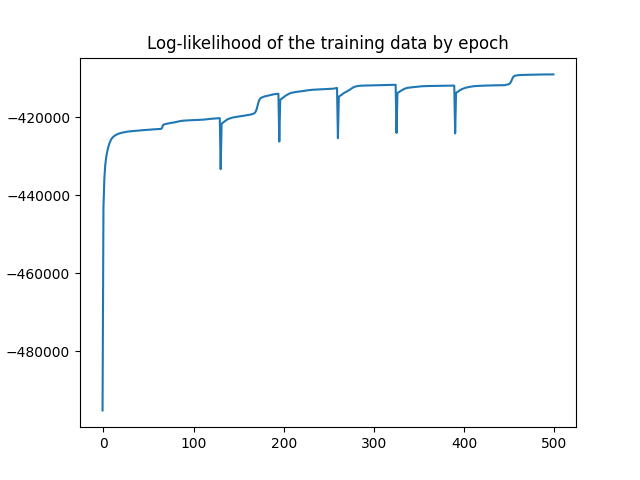

Test log-likelihood: -104127.61935215678
——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


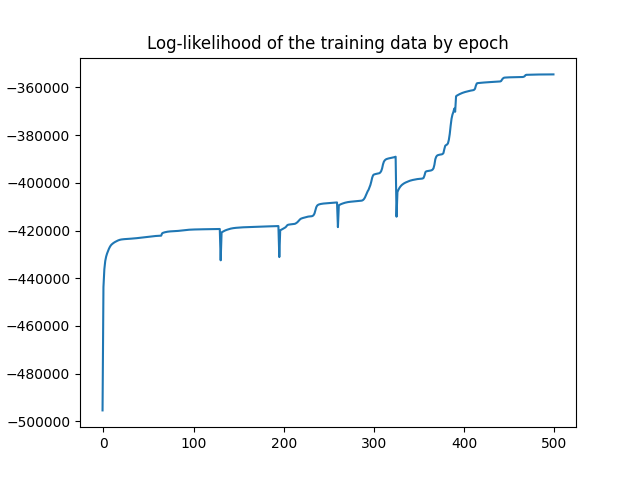

Test log-likelihood: -92060.76501219155
——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.


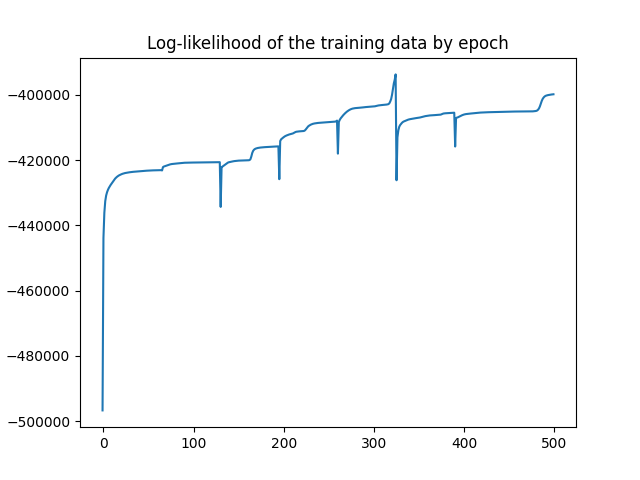

Test log-likelihood: -98053.89706814935
——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


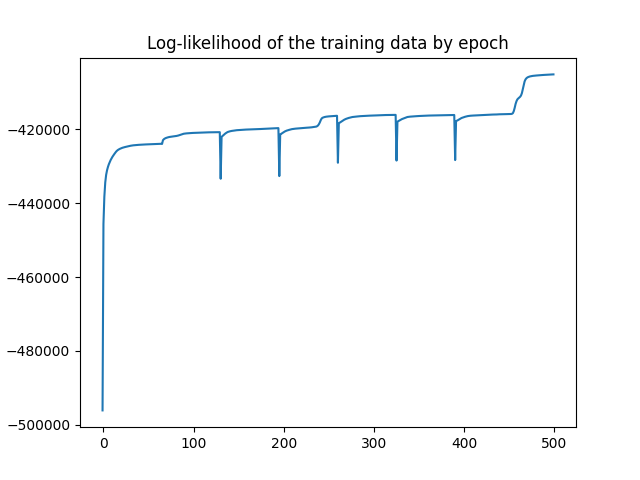

Test log-likelihood: -101179.2003408595
——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.


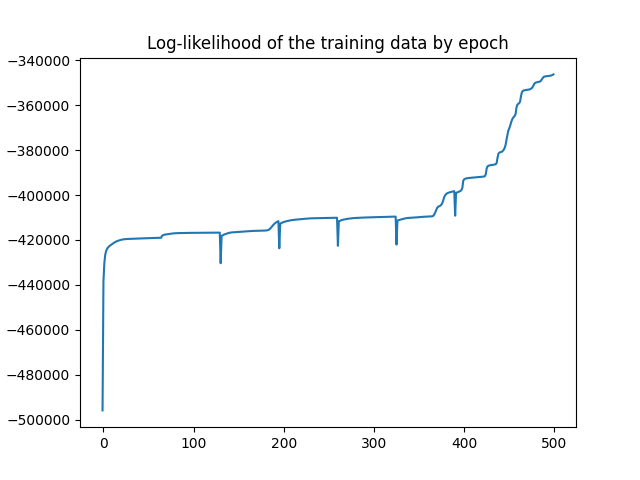

Test log-likelihood: -95807.19061496574


In [11]:
RETRAIN_ALL = True
if RETRAIN_ALL:
    print("WARNING: This will overwrite previously saved models if there are any!")
    print("Press enter to continue")
    input()

log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    save_file_path = f'./saved_models/continuous_treatment_rspn_mimic_structure_train_{seed}.pkl'
    if not RETRAIN_ALL and os.path.exists(save_file_path):
        print(f"Loading pre-trained model for seed {seed}")
        with open(save_file_path, 'rb') as f:
            optimized_iohmm_rspn = dill.load(f)
    else:
        train_observations = train_mimic_datasets[i].observations_raw_continuous
        train_inputs = train_mimic_datasets[i].inputs_raw
        iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, seed)
        train_data = train_mimic_datasets[i].spn_data_continuous
        optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params, plot_identifier=f"mimic_structure_{seed}", live_figure=live_figures[i])
        with open(save_file_path, 'wb') as f:
            dill.dump(optimized_iohmm_rspn, f)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    print(f"Test log-likelihood: {data_log_likelihood}")
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [12]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -98245.73447766458
STD: 4181.840185806708
All: [-104127.61935215678, -92060.76501219155, -98053.89706814935, -101179.2003408595, -95807.19061496574]
Median seed: 44


In [13]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_mimic_structure_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

Press enter to continue


Ok, models saved


In [14]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_mimic_structure_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

Ok, models loaded


In [15]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -98245.73447766458
STD: 4181.840185806708
All: [-104127.61935215678, -92060.76501219155, -98053.89706814935, -101179.2003408595, -95807.19061496574]
Median seed: 44


## Treatment-RSPN with Structure Learning — higher NUM_STATES

In [6]:
NUM_STATES = 40

In [7]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=65,
    structure_learning_final_pause=100,
    num_epochs=500,
)

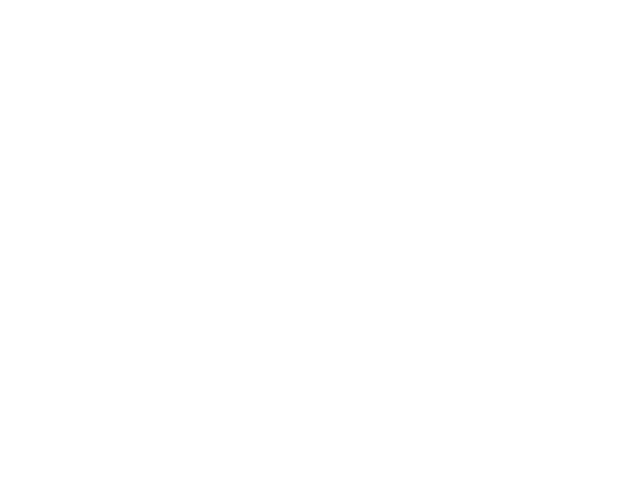

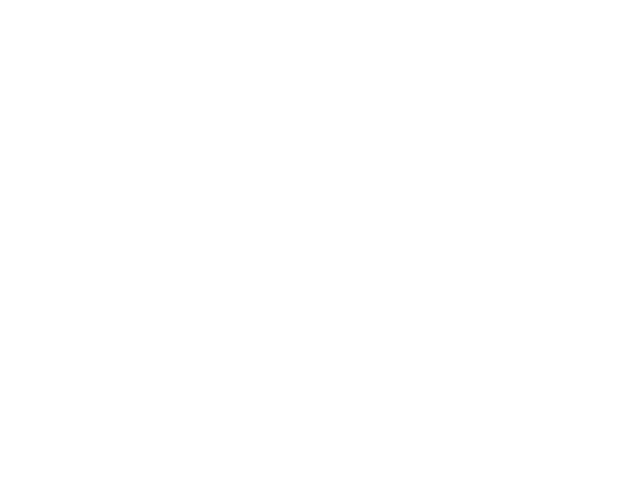

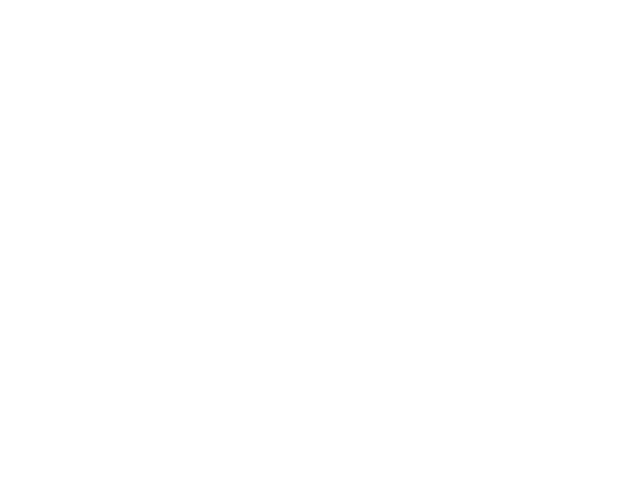

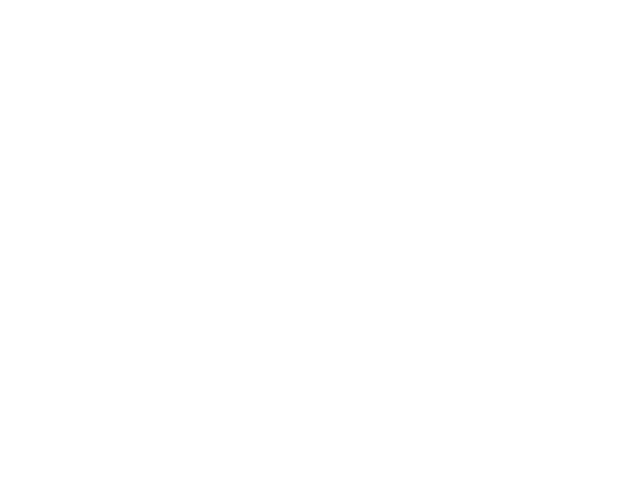

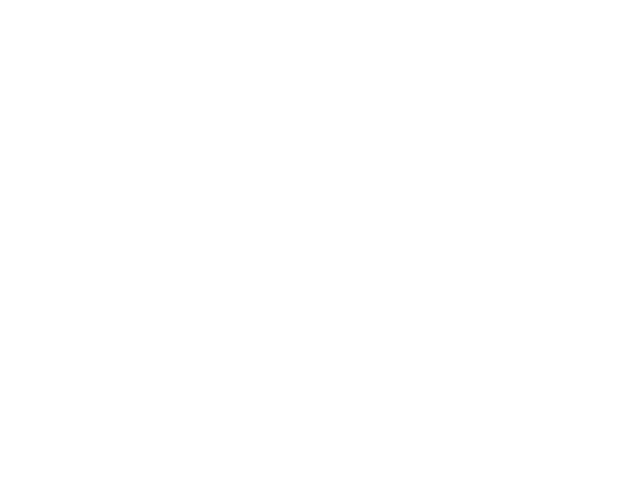

In [8]:
%matplotlib widget
live_figures = []
for seed in SEEDS:
    figure = plt.figure()
    live_figures.append(figure)

Press enter to continue


——————————[ Running experiment for seed 42 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -333686.34542190353 (AVG: -69.91123935091211)


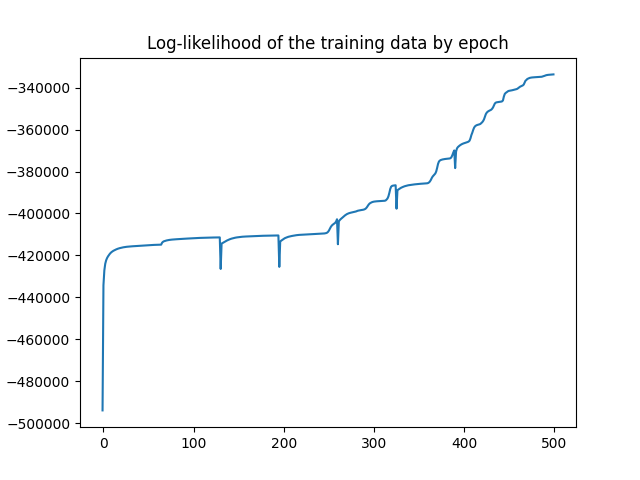

Test log-likelihood: -84885.3506883174
——————————[ Running experiment for seed 43 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -342392.6251262658 (AVG: -71.73530800885518)


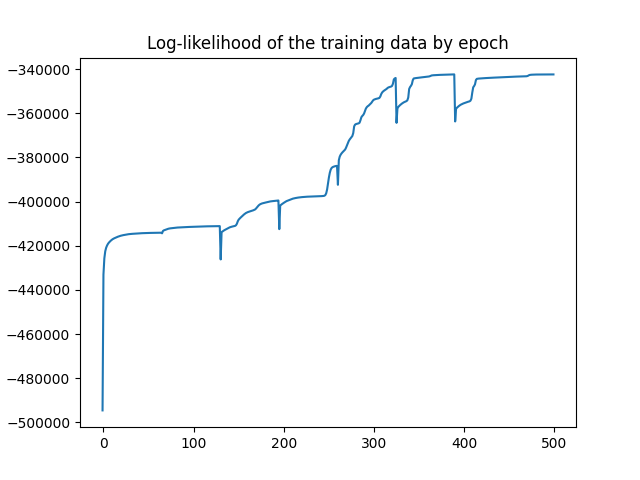

Test log-likelihood: -90015.4292836729
——————————[ Running experiment for seed 44 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -400358.63627258275 (AVG: -83.86230336669098)


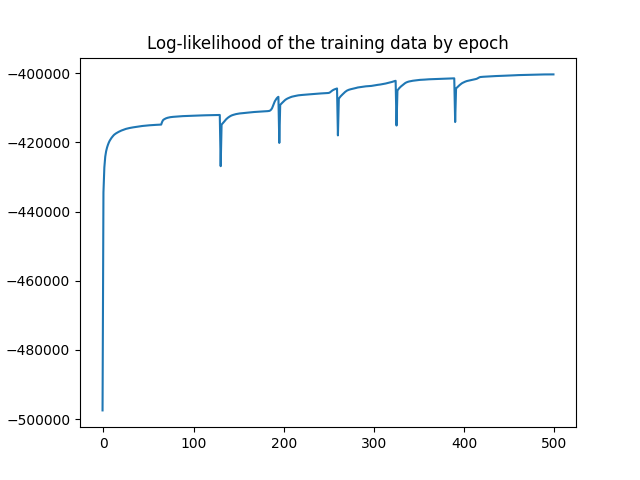

Test log-likelihood: -101969.7175988995
——————————[ Running experiment for seed 45 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -404463.6928093717 (AVG: -84.72218114984744)


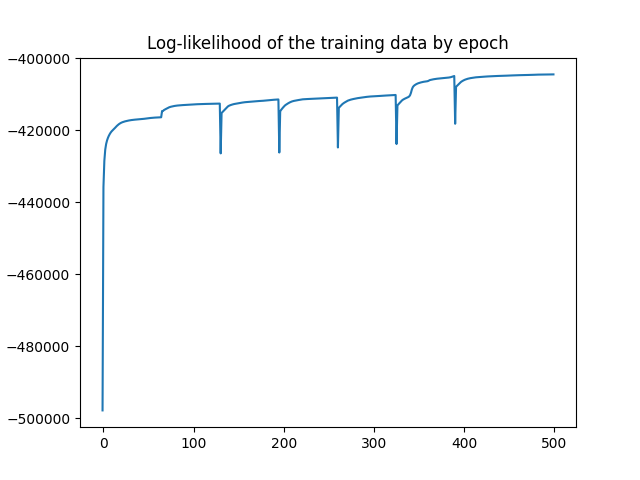

Test log-likelihood: -102417.21472392388
——————————[ Running experiment for seed 46 ]——————————
Training ContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -330794.4550870139 (AVG: -69.29083684269249)


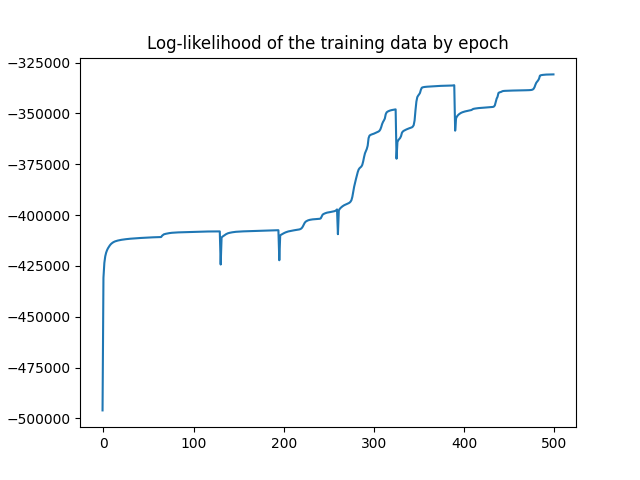

Test log-likelihood: -94783.39605825374


In [9]:
RETRAIN_ALL = True
if RETRAIN_ALL:
    print("WARNING: This will overwrite previously saved models if there are any!")
    print("Press enter to continue")
    input()

log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    save_file_path = f'./saved_models/continuous_treatment_rspn_mimic_structure_train_40_states_{seed}.pkl'
    if not RETRAIN_ALL and os.path.exists(save_file_path):
        print(f"Loading pre-trained model for seed {seed}")
        with open(save_file_path, 'rb') as f:
            optimized_iohmm_rspn = dill.load(f)
    else:
        train_observations = train_mimic_datasets[i].observations_raw_continuous
        train_inputs = train_mimic_datasets[i].inputs_raw
        iohmm_rspn = ContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, seed)
        train_data = train_mimic_datasets[i].spn_data_continuous
        optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params, plot_identifier=f"mimic_structure_40_states_{seed}", live_figure=live_figures[i])
        with open(save_file_path, 'wb') as f:
            dill.dump(optimized_iohmm_rspn, f)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    print(f"Test log-likelihood: {data_log_likelihood}")
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [10]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -94814.22167061348
STD: 6791.442599666458
All: [-84885.3506883174, -90015.4292836729, -101969.7175988995, -102417.21472392388, -94783.39605825374]
Median seed: 46


In [11]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_mimic_structure_40_states_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

Press enter to continue


Ok, models saved


In [12]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/continuous_treatment_rspn_mimic_structure_40_states_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

Ok, models loaded


In [13]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -94814.22167061348
STD: 6791.442599666458
All: [-84885.3506883174, -90015.4292836729, -101969.7175988995, -102417.21472392388, -94783.39605825374]
Median seed: 46


## Overparameterised Continuous Treatment-RSPN with Structure Learning

In [19]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=65,
    structure_learning_final_pause=100,
    num_epochs=500,
)

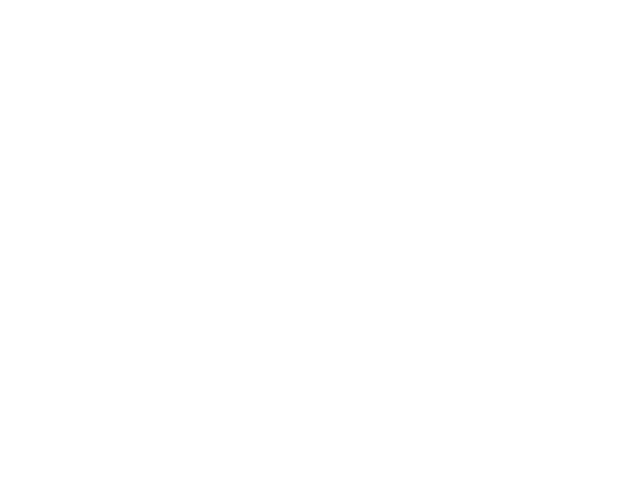

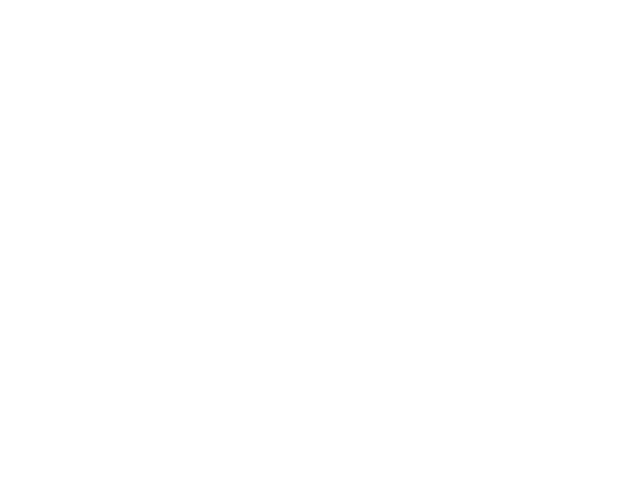

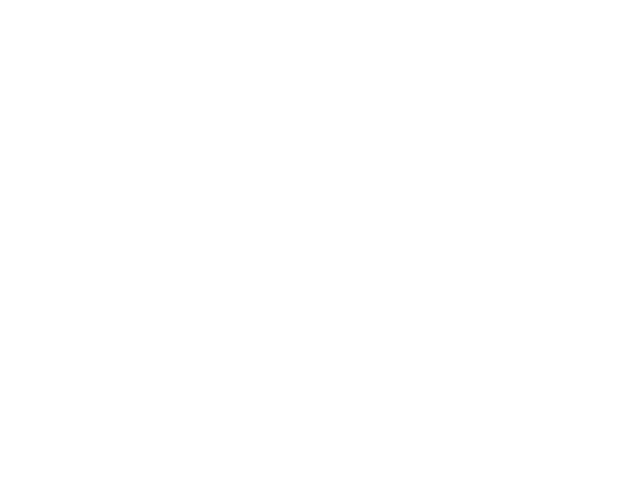

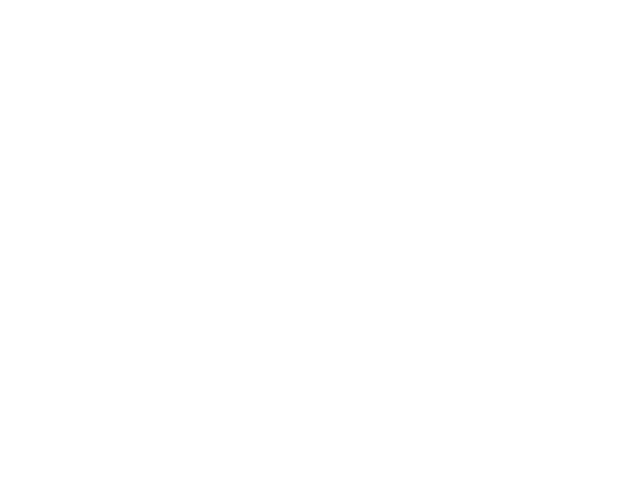

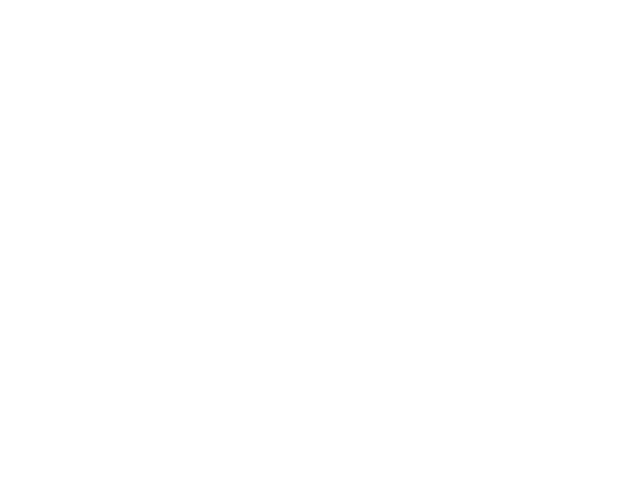

In [20]:
%matplotlib widget
live_figures = []
for seed in SEEDS:
    figure = plt.figure()
    live_figures.append(figure)

Press enter to continue


——————————[ Running experiment for seed 42 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -336410.1122568997 (AVG: -70.4819007452126)


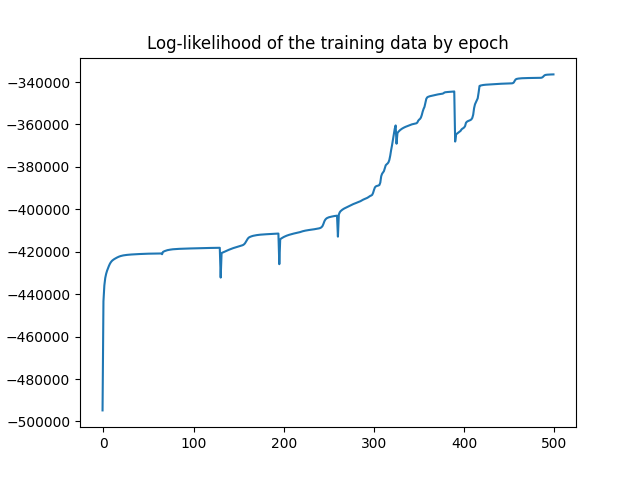

Test log-likelihood: -85368.80076299378
——————————[ Running experiment for seed 43 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
INFO: The best model was not the final model. Returning best model.
Best likelihood: -334708.2649568437 (AVG: -70.12534359037161)


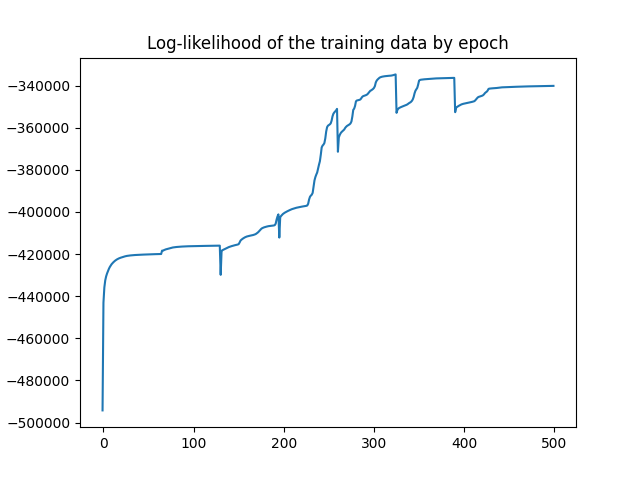

Test log-likelihood: -87212.76245521971
——————————[ Running experiment for seed 44 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -342265.70904183603 (AVG: -71.69369690863763)


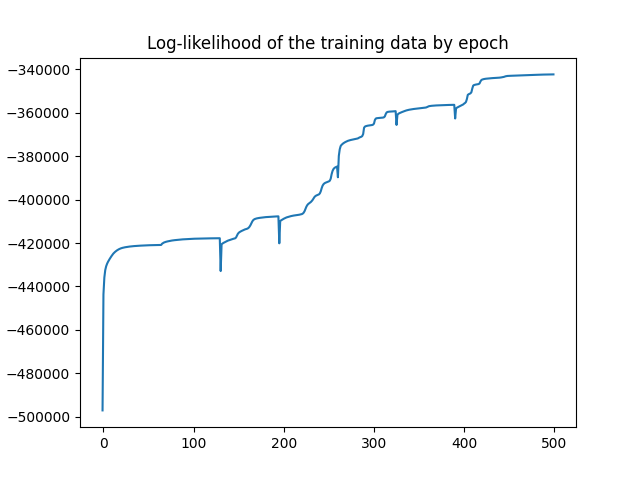

Test log-likelihood: -85163.00106178311
——————————[ Running experiment for seed 45 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -339021.0814968158 (AVG: -71.01405142371507)


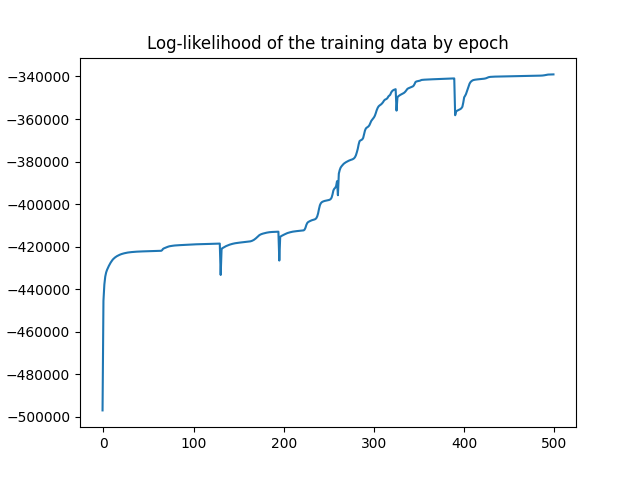

Test log-likelihood: -84823.34341510208
——————————[ Running experiment for seed 46 ]——————————
Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/500 [00:00<?, ?it/s]

Training complete.
Best likelihood: -330476.74766467337 (AVG: -69.22428731978914)


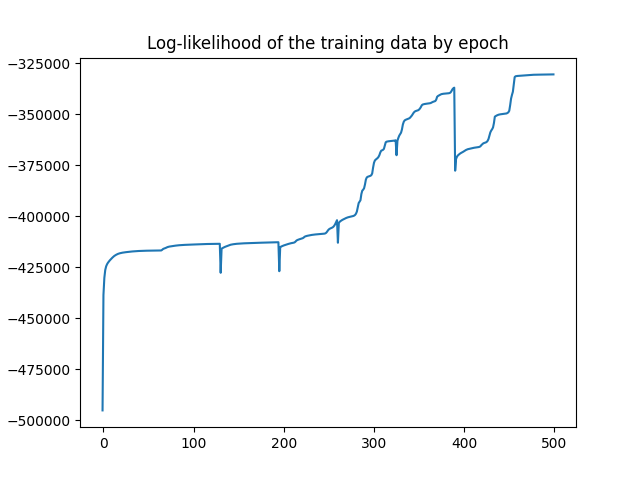

Test log-likelihood: -94144.33038251623


In [23]:
RETRAIN_ALL = True
if RETRAIN_ALL:
    print("WARNING: This will overwrite previously saved models if there are any!")
    print("Press enter to continue")
    input()

log_likelihoods = []
iohmm_rspn_models = []
for i, seed in enumerate(SEEDS):
    print(f"——————————[ Running experiment for seed {seed} ]——————————")
    save_file_path = f'./saved_models/overparametrised_continuous_treatment_rspn_mimic_structure_train_{seed}.pkl'
    if not RETRAIN_ALL and os.path.exists(save_file_path):
        print(f"Loading pre-trained model for seed {seed}")
        with open(save_file_path, 'rb') as f:
            optimized_iohmm_rspn = dill.load(f)
    else:
        train_observations = train_mimic_datasets[i].observations_raw_continuous
        train_inputs = train_mimic_datasets[i].inputs_raw
        iohmm_rspn = OverparametrisedContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, seed)
        train_data = train_mimic_datasets[i].spn_data_continuous
        optimized_iohmm_rspn = iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params, plot_identifier=f"mimic_structure_{seed}", live_figure=live_figures[i])
        with open(save_file_path, 'wb') as f:
            dill.dump(optimized_iohmm_rspn, f)
    data_log_likelihood = log_likelihood(optimized_iohmm_rspn.unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    print(f"Test log-likelihood: {data_log_likelihood}")
    log_likelihoods.append(data_log_likelihood)
    iohmm_rspn_models.append(optimized_iohmm_rspn)

In [24]:
print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -87342.44761552298
STD: 3500.6737228255893
All: [-85368.80076299378, -87212.76245521971, -85163.00106178311, -84823.34341510208, -94144.33038251623]
Median seed: 42


In [25]:
# Save the trained models
print("WARNING: This will overwrite previously saved models if there are any!")
print("Press enter to continue")
input()
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/overparametrised_continuous_treatment_rspn_mimic_structure_{seed}.pkl', 'wb') as f:
        dill.dump(iohmm_rspn_models[i], f)
print("Ok, models saved")

Press enter to continue


Ok, models saved


In [26]:
# Load the trained models
iohmm_rspn_loaded_models = []
for i, seed in enumerate(SEEDS):
    with open(f'./saved_models/overparametrised_continuous_treatment_rspn_mimic_structure_{seed}.pkl', 'rb') as f:
        iohmm_rspn_loaded_models.append(dill.load(f))
print("Ok, models loaded")

Ok, models loaded


In [27]:
log_likelihoods = []
for i, seed in enumerate(SEEDS):
    data_log_likelihood = log_likelihood(iohmm_rspn_loaded_models[i].unroll(SEQ_LENGTH), test_mimic_datasets[i].spn_data_continuous).sum()
    log_likelihoods.append(data_log_likelihood)

print("——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————")
print(f"Mean: {np.array(log_likelihoods).mean()}")
print(f"STD: {np.array(log_likelihoods).std()}")
print(f"All: {log_likelihoods}")
print(f"Median seed: {SEEDS[np.argsort(log_likelihoods)[len(log_likelihoods)//2]]}")

——————————[ Continuous IOHMM-RSPN log-likelihood ]——————————
Mean: -87342.44761552298
STD: 3500.6737228255893
All: [-85368.80076299378, -87212.76245521971, -85163.00106178311, -84823.34341510208, -94144.33038251623]
Median seed: 42


## Profiling

In [13]:
training_params = EMTrainingParams(
    structure_learning=True,
    structure_learning_pause=5,
    structure_learning_final_pause=1,
    num_epochs=10,
)

In [14]:
train_observations = train_mimic_datasets[0].observations_raw_continuous
train_inputs = train_mimic_datasets[0].inputs_raw
iohmm_rspn = OverparametrisedContinuousIoHmmRSPN.construct_gmm_em(train_observations, train_inputs, num_inputs, NUM_STATES, observations_dim, 42, 2)
train_data = train_mimic_datasets[0].spn_data_continuous

Training OverparametrisedContinuousIoHmmRSPN using EM...


  0%|          | 0/10 [00:00<?, ?it/s]

Training complete.
Best likelihood: -424027.3357600821 (AVG: -88.83874623089925)


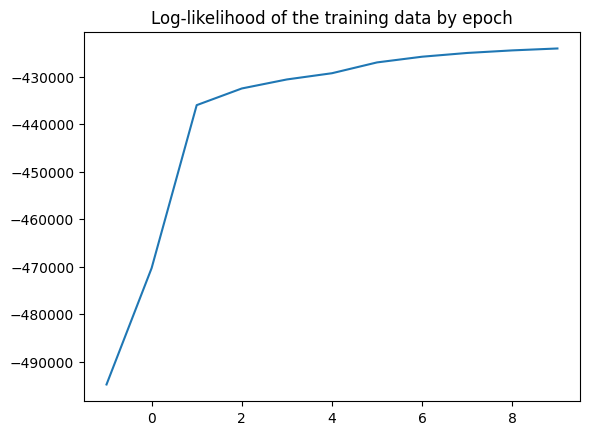

In [15]:
# %%tuna
iohmm_rspn.train_em(train_data, SEQ_LENGTH, training_params=training_params)

## LSTM Continuous Outcome Prediction

In [ ]:
aggregate_metrics = get_empty_metrics(regression=True, num_variables=observations_dim)
for i, seed in enumerate(SEEDS):
    _, _, metrics = train_eval_lstm(
        train_mimic_datasets[i], 
        test_mimic_datasets[i],
        num_inputs,
        observations_dim,
        seed,
        action_prediction=False,
        continuous=True
    )
    add_metrics(aggregate_metrics, metrics)

In [ ]:
print("——————————[ LSTM regression performance ]——————————")
print_aggregate_metrics(aggregate_metrics)